In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime
import ast
from decimal import Decimal, ROUND_UP
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import altair as alt

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose as s_dec
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from collections import defaultdict

In [8]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [9]:
def normalize_ts (metric_to_normalize):
    
    values = metric_to_normalize.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    normalized = scaler.transform(values)

    return normalized

In [10]:
def simple_plot (index, values=None, title_plot=None, save=None):
    
    if values is None:
        values=index
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(index.index, values)
    
    if title_plot is not None:
        fig.suptitle(title_plot, fontsize=18)

    ax.grid(True)
    
    ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.xlabel('year', fontsize=16)
    plt.ylabel('values', fontsize=16)

    if save:
        title = title_plot.replace(" ", "_") + "png"
        plt.savefig(title, dpi = 300, facecolor='w')
               
    plt.show()
    

    
def decomposition_plot (metric, trend, seasonal, residual, title, save=None):

    fig, ax = plt.subplots (4, sharex=True, figsize = (20,10))
    
    fig.suptitle(title, fontsize=20)
    
    ax[0].plot(metric)
    ax[0].set(title="Original")
    ax[0].grid()
    
    
    ax[1].plot(trend)
    ax[1].set(title="Trend")
    ax[1].grid()
    
    ax[2].plot(seasonal)
    ax[2].set(title="Seasonality")
    ax[2].grid()
    
    ax[3].plot(residual)
    ax[3].set(title="Residual")
    ax[3].grid()
    ax[3].set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])
    
    plt.xticks(fontsize=13)
    
    if save:
        title = title_plot.replace(" ", "_") + "png"
        plt.savefig(title, dpi = 300, facecolor='w')
    
    plt.show()
    
    
def line_trend_plot (index, trend_index, values=None, trend_values=None, title_plot=None, save=None):

    if values is None:
        values=index
    
    if trend_values is None:
        trend_values=trend_index
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.grid(True)
    
    if title_plot is not None:
        fig.suptitle(title_plot, fontsize=18)

    year = mdates.YearLocator(month=1)
    month = mdates.MonthLocator(interval=3)

    ax.xaxis.set_minor_locator(month)
    ax.xaxis.set_major_locator(year)
    ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

    plt.plot(index.index, values, linewidth=2)
    plt.plot(trend_index.index, trend_values, c='red', linewidth=2)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel('year', fontsize=15)
    plt.ylabel('values', fontsize=15)

    if save:
        title = title_plot.replace(" ", "_") + "png"
        plt.savefig(title, dpi = 300, facecolor='w')

    plt.show()
    
    
    
def simple_seasonal_plot (data, title_plot=None, save=None):
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.grid(True)

    plt.plot(data.groupby(noindex_tempo["date_chart"].dt.month)["seasonal"].mean())

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if title_plot is not None:
        ax.set_title(title_plot, fontsize=15)
    
    ax.set_xlabel("months", fontsize=15)
    ax.set_ylabel("values", fontsize=15)

    if save:
        title = title_plot.replace(" ", "_") + "png"
        plt.savefig(title, dpi = 300, facecolor='w')

    plt.show()

In [11]:
PATH = 'combined_df_final_nospace.csv'

In [12]:
df = pd.read_csv(PATH, sep=";", index_col=False)

In [13]:
df['date_chart'] = pd.to_datetime(df['date_chart'], format= '%d.%m.%Y')
df['year'] = df['date_chart'].dt.year
df['month'] = df['date_chart'].dt.month

In [14]:
df = df.set_index("date_chart")
df.head()

original_song_name  original_artists_name  curr_rank tag_fimi  \
date_chart                                                                     
2006-05-07  svegliarsi la mattina          zero assoluto          1      sgo   
2006-05-07                    one     mary j. blige & u2          2      uni   
2006-05-07         sei nell'anima         gianna nannini          3      uni   
2006-05-07            upside down           jack johnson          4      uni   
2006-05-07        dani california  red hot chili peppers          5      wmi   

           publisher album_release_date   album_type              song_name  \
date_chart                                                                    
2006-05-07       NaN         2006-02-28       single  Svegliarsi la mattina   
2006-05-07       NaN         2021-06-10  compilation       One - Radio Edit   
2006-05-07       NaN         2006-11-27        album         Sei nell'anima   
2006-05-07       NaN               2006        album            Upside Down   
2006-05-07       NaN         2006-04-03       single        Dani California   

                          album_id              artists_names  ...    tempo  \
date_chart                                                     ...            
2006-05-07  6d1AvZ3brZ9caD2cFbIbbd          ['Zero Assoluto']  ...  171.970   
2006-05-07  1JTnevVl46CyP8Zj1rcUX4    ['Mary J. Blige', 'U2']  ...  185.908   
2006-05-07  2htq51kTRL2dwMxa2mBfJi         ['Gianna Nannini']  ...   91.010   
2006-05-07  0kYv61g7n6ZPe2TVaIBeeJ           ['Jack Johnson']  ...  102.476   
2006-05-07  3rrvHWzZCF8TvqT9oJtfVZ  ['Red Hot Chili Peppers']  ...   96.184   

                      type                      id  \
date_chart                                           
2006-05-07  audio_features  1ecMdfIXNksJTymYlzsFZ3   
2006-05-07  audio_features  7xtCBkcqlum3X6l7bN3tza   
2006-05-07  audio_features  6shzlUkm7OcnoO4guEiGJ8   
2006-05-07  audio_features  3YOigAKOgFTQuLjF9MBmd3   
2006-05-07  audio_features  6vODhpvfWwdsO0i9MBWnEq   

                                                          uri  \
date_chart                                                      
2006-05-07  https://api.spotify.com/v1/tracks/1ecMdfIXNksJ...   
2006-05-07               spotify:track:7xtCBkcqlum3X6l7bN3tza   
2006-05-07  https://api.spotify.com/v1/tracks/6shzlUkm7Ocn...   
2006-05-07  https://api.spotify.com/v1/tracks/3YOigAKOgFTQ...   
2006-05-07  https://api.spotify.com/v1/tracks/6vODhpvfWwds...   

                                                   track_href  \
date_chart                                                      
2006-05-07  https://api.spotify.com/v1/audio-analysis/1ecM...   
2006-05-07  https://api.spotify.com/v1/tracks/7xtCBkcqlum3...   
2006-05-07  https://api.spotify.com/v1/audio-analysis/6shz...   
2006-05-07  https://api.spotify.com/v1/audio-analysis/3YOi...   
2006-05-07  https://api.spotify.com/v1/audio-analysis/6vOD...   

                                                 analysis_url  duration_ms  \
date_chart                                                                   
2006-05-07                                             223053          4.0   
2006-05-07  https://api.spotify.com/v1/audio-analysis/7xtC...     243627.0   
2006-05-07                                             270347          4.0   
2006-05-07                                             208653          4.0   
2006-05-07                                             282160          4.0   

            time_signature  year  month  
date_chart                               
2006-05-07             NaN  2006      5  
2006-05-07             4.0  2006      5  
2006-05-07             NaN  2006      5  
2006-05-07             NaN  2006      5  
2006-05-07             NaN  2006      5  

[5 rows x 35 columns]

In [15]:
df = df.dropna(axis=0, subset=['song_id'])
df

original_song_name  \
date_chart                             
2006-05-07     svegliarsi la mattina   
2006-05-07                       one   
2006-05-07            sei nell'anima   
2006-05-07               upside down   
2006-05-07           dani california   
...                              ...   
2021-05-20          una volta ancora   
2021-05-20           blinding lights   
2021-05-20             non fare così   
2021-05-20                  altalene   
2021-05-20  smith & wesson freestyle   

                                        original_artists_name  curr_rank  \
date_chart                                                                 
2006-05-07                                      zero assoluto          1   
2006-05-07                                 mary j. blige & u2          2   
2006-05-07                                     gianna nannini          3   
2006-05-07                                       jack johnson          4   
2006-05-07                              red hot chili peppers          5   
...                                                       ...        ...   
2021-05-20                       fred de palma feat. ana mena         96   
2021-05-20                                         the weeknd         97   
2021-05-20                                         capo plaza         98   
2021-05-20  bloody vinyl, slait, tha supreme feat. mara sa...         99   
2021-05-20                  guè pequeno, dj harsh & marracash        100   

                                  tag_fimi     publisher album_release_date  \
date_chart                                                                    
2006-05-07                             sgo           NaN         2006-02-28   
2006-05-07                             uni           NaN         2021-06-10   
2006-05-07                             uni           NaN         2006-11-27   
2006-05-07                             uni           NaN               2006   
2006-05-07                             wmi           NaN         2006-04-03   
...                                    ...           ...                ...   
2021-05-20                        wm italy  warner music         2019-09-13   
2021-05-20                          island           uni         2020-03-20   
2021-05-20  plaza music/atlantic /wm italy  warner music         2021-01-22   
2021-05-20                          arista           sme         2020-10-02   
2021-05-20                          island           uni         2021-04-08   

             album_type                                   song_name  \
date_chart                                                            
2006-05-07       single                       Svegliarsi la mattina   
2006-05-07  compilation                            One - Radio Edit   
2006-05-07        album                              Sei nell'anima   
2006-05-07        album                                 Upside Down   
2006-05-07       single                             Dani California   
...                 ...                                         ...   
2021-05-20        album           Una volta ancora (feat. Ana Mena)   
2021-05-20        album                             Blinding Lights   
2021-05-20        album                               Non Fare Così   
2021-05-20        album         ALTALENE (feat. Mara Sattei & Coez)   
2021-05-20        album  Smith & Wesson Freestyle (feat. Marracash)   

                          album_id  \
date_chart                           
2006-05-07  6d1AvZ3brZ9caD2cFbIbbd   
2006-05-07  1JTnevVl46CyP8Zj1rcUX4   
2006-05-07  2htq51kTRL2dwMxa2mBfJi   
2006-05-07  0kYv61g7n6ZPe2TVaIBeeJ   
2006-05-07  3rrvHWzZCF8TvqT9oJtfVZ   
...                            ...   
2021-05-20  6ZWT9vaRmBayZ6wpm7c5Un   
2021-05-20  4yP0hdKOZPNshxUOjY0cZj   
2021-05-20  5tKxGn7nxBF5qLW6cpwVT8   
2021-05-20  6qAapBZqjiATXktzwBzzLC   
2021-05-20  1ay6WuRZa6LUTNN9A6JRk6   

                                                artists_names

In [16]:
#dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
#df = pd.read_csv(PATH, sep=";", parse_dates=True, index_col='date_chart', date_parser=dateparse)
#df.head()

**Variabili

In [17]:
song_number, explicit, number_artists, valence, danceability, duration, energy, loudness, mode, speechiness, acousticness, instrumentalness, liveness, tempo  = df['id'], df['explicit'], df['artists_id'], df['valence'], df['danceability'], df['duration'], df['energy'], df['loudness'], df['mode'], df['speechiness'], df['acousticness'], df['instrumentalness'], df['liveness'], df['tempo']

song_number = song_number.resample("Y").count()

number_artists = number_artists.transform(ast.literal_eval).str.len()
number_artists = number_artists.resample("M").mean()
    
explicit = explicit.resample("M").sum()/explicit.resample('M').count()

valence = valence.resample("M").mean()
danceability = danceability.resample("M").mean()
duration = duration.resample("M").mean()
energy = energy.resample("M").mean()
loudness = loudness.resample("M").mean()
mode = mode.resample("M").mean()
speechiness = speechiness.resample("M").mean()
acousticness = acousticness.resample("M").mean()
instrumentalness = instrumentalness.resample("M").mean()
liveness = liveness.resample("M").mean()
tempo = tempo.resample("M").mean() 

**Filter only the Covid's period and from 2012 to today

In [18]:
covid_time = df.loc[df.index > '2019-03-01']

In [19]:
covid_valence, covid_danceability, covid_duration, covid_energy, covid_loudness, covid_mode, covid_speechiness, covid_acousticness, covid_instrumentalness, covid_liveness, covid_tempo  = covid_time['valence'], covid_time['danceability'], covid_time['duration'], covid_time['energy'], covid_time['loudness'], covid_time['mode'], covid_time['speechiness'], covid_time['acousticness'], covid_time['instrumentalness'], covid_time['liveness'], covid_time['tempo']

covid_valence = covid_valence.resample("M").mean()
covid_danceability = covid_danceability.resample("M").mean()
covid_duration = covid_duration.resample("M").mean()
covid_energy = covid_energy.resample("M").mean()
covid_loudness = covid_loudness.resample("M").mean()
covid_mode = covid_mode.resample("M").mean()
covid_speechiness = covid_speechiness.resample("M").mean()
covid_acousticness = covid_acousticness.resample("M").mean()
covid_instrumentalness = covid_instrumentalness.resample("M").mean()
covid_liveness = covid_liveness.resample("M").mean()
covid_tempo = covid_tempo.resample("M").mean()

**Dal 2012 al 2021

In [20]:
count_time = df.loc[(df.index > '2012-01-01') & (df.index < '2021-01-01')]

#### Decompositions

In [21]:
dec_number_artists, dec_duration, dec_valence, dec_danceability, dec_energy, dec_loudness, dec_mode, dec_speechiness = s_dec(number_artists), s_dec(duration), s_dec(valence), s_dec(danceability), s_dec(energy), s_dec(loudness), s_dec(mode), s_dec(speechiness)
dec_explicit, dec_acousticness, dec_instrumentalness, dec_liveness, dec_tempo = s_dec(explicit), s_dec(acousticness), s_dec(instrumentalness), s_dec(liveness), s_dec(tempo)

trend_number_artists, trend_duration, trend_explicit, trend_valence, trend_danceability, trend_energy, trend_loudness = dec_number_artists.trend, dec_duration.trend, dec_explicit.trend, dec_valence.trend, dec_danceability.trend, dec_energy.trend, dec_loudness.trend
trend_mode, trend_speechiness, trend_acousticness, trend_instrumentalness, trend_liveness, trend_tempo = dec_mode.trend, dec_speechiness.trend, dec_acousticness.trend, dec_instrumentalness.trend, dec_liveness.trend, dec_tempo.trend

seasonal_number_artists, seasonal_duration, seasonal_explicit, seasonal_valence, seasonal_danceability, seasonal_energy, seasonal_loudness = dec_number_artists.seasonal, dec_duration.seasonal, dec_explicit.seasonal, dec_valence.seasonal, dec_danceability.seasonal, dec_energy.seasonal, dec_loudness.seasonal    
seasonal_mode, seasonal_speechiness, seasonal_acousticness, seasonal_instrumentalness, seasonal_liveness, seasonal_tempo = dec_mode.seasonal, dec_speechiness.seasonal, dec_acousticness.seasonal, dec_instrumentalness.seasonal, dec_liveness.seasonal, dec_tempo.seasonal

residual_number_artists, residual_duration, residual_explicit, residual_valence, residual_danceability, residual_energy, residual_loudness = dec_number_artists.resid, dec_duration.resid, dec_explicit.resid, dec_valence.resid, dec_danceability.resid, dec_energy.resid, dec_loudness.resid    
residual_mode, residual_speechiness, residual_acousticness, residual_instrumentalness, residual_liveness, residual_tempo = dec_mode.resid, dec_speechiness.resid, dec_acousticness.resid, dec_instrumentalness.resid, dec_liveness.resid, dec_tempo.resid 

#### Seasonality

In [22]:
dfnoindex = df.reset_index()

#Queste sono le stagionalità decomposte
noindex_danceability = seasonal_danceability.reset_index()
noindex_valence = seasonal_valence.reset_index()
noindex_duration = seasonal_duration.reset_index()
noindex_energy = seasonal_energy.reset_index()
noindex_loudness = seasonal_loudness.reset_index()
noindex_speechiness = seasonal_speechiness.reset_index()
noindex_mode = seasonal_mode.reset_index()
noindex_acousticness = seasonal_acousticness.reset_index()
noindex_instrumentalness = seasonal_instrumentalness.reset_index()
noindex_liveness = seasonal_liveness.reset_index()
noindex_tempo = seasonal_tempo.reset_index()

#### Normalizations

In [23]:
norm_tempo = normalize_ts(tempo)

# Number of songs

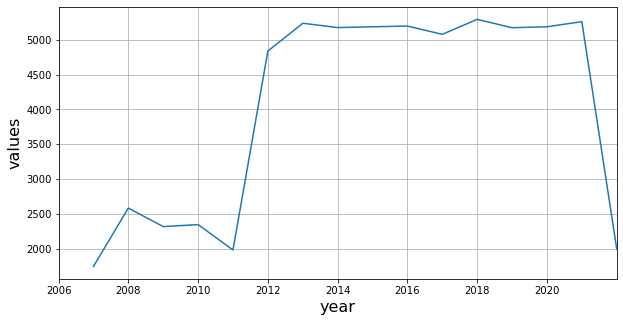

In [24]:
simple_plot (song_number)

# Number of artists

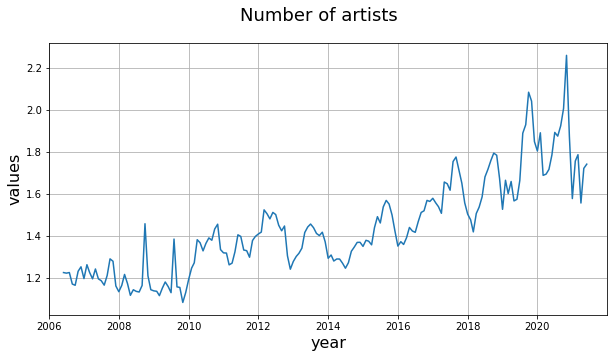

In [25]:
simple_plot (number_artists, title_plot="Number of artists")

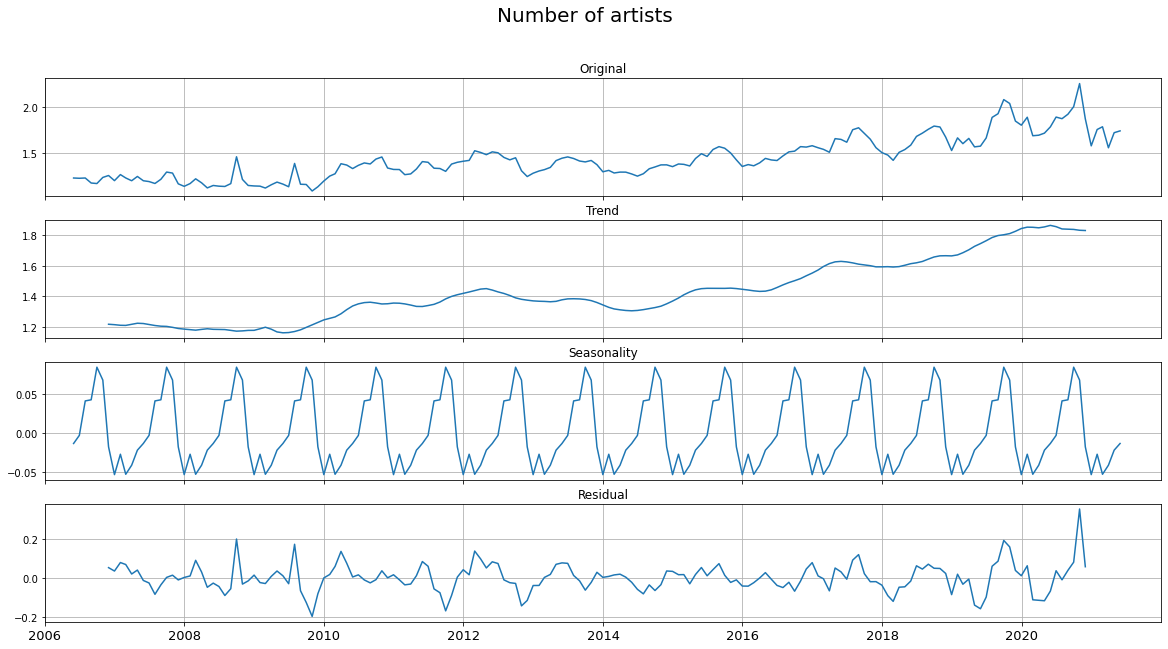

In [26]:
decomposition_plot (number_artists, trend_number_artists, seasonal_number_artists, residual_number_artists, "Number of artists")

# Most frequent artists

#### Da fare

# Explicit

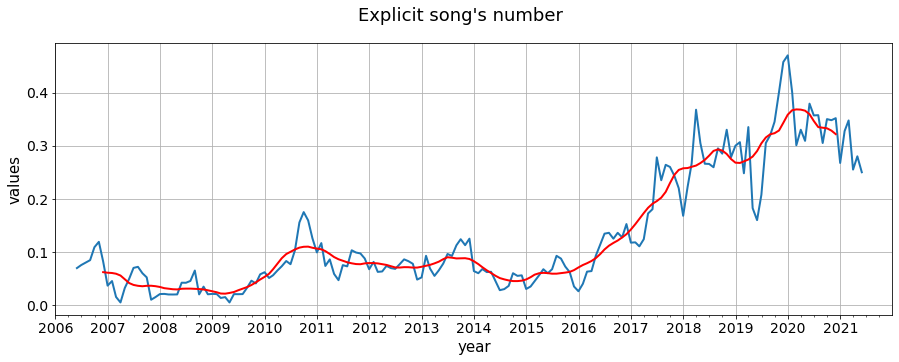

In [27]:
line_trend_plot (explicit, trend_explicit, title_plot="Explicit song's number")

# Duration

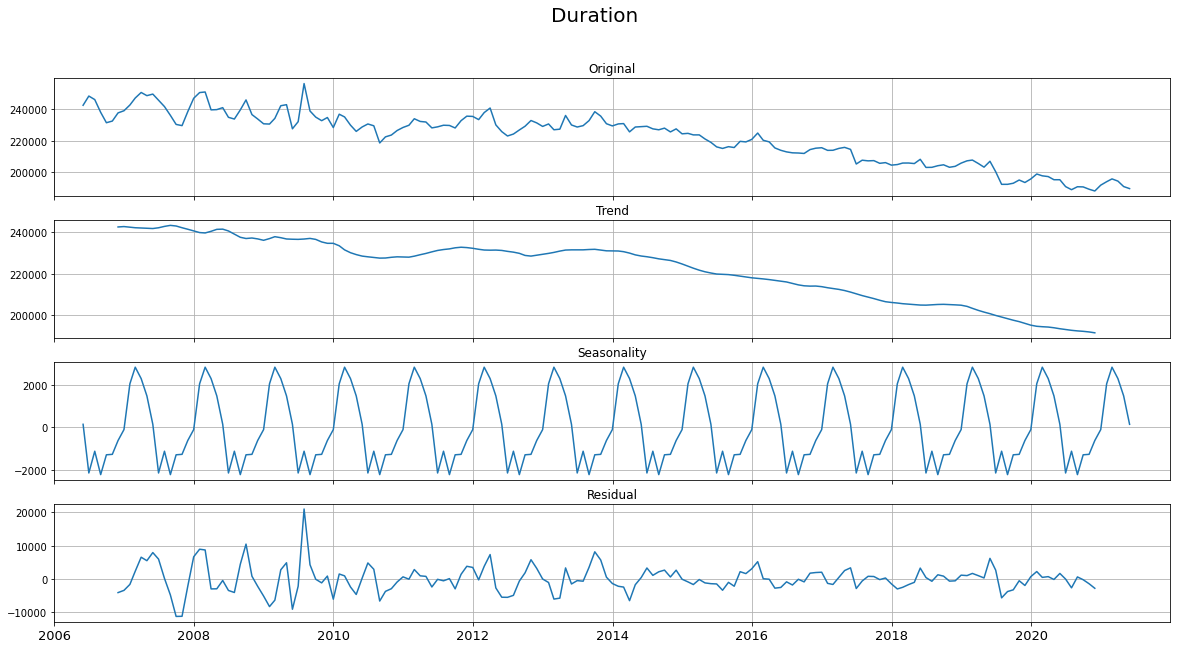

In [28]:
decomposition_plot(duration, trend_duration, seasonal_duration, residual_duration, "Duration")

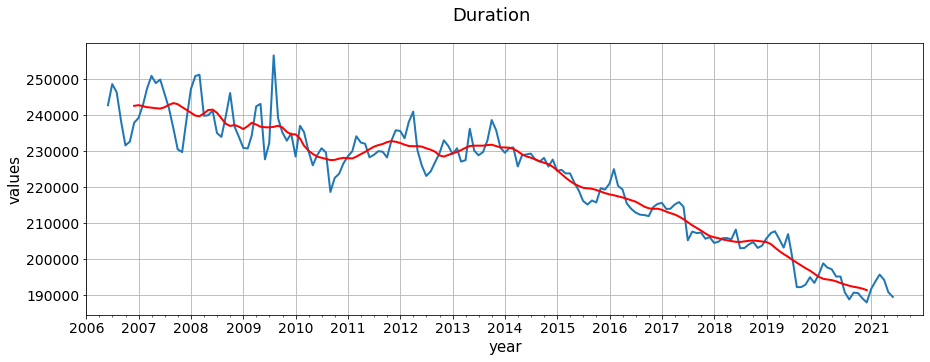

In [29]:
line_trend_plot (duration, trend_duration, title_plot= "Duration")

# Valence

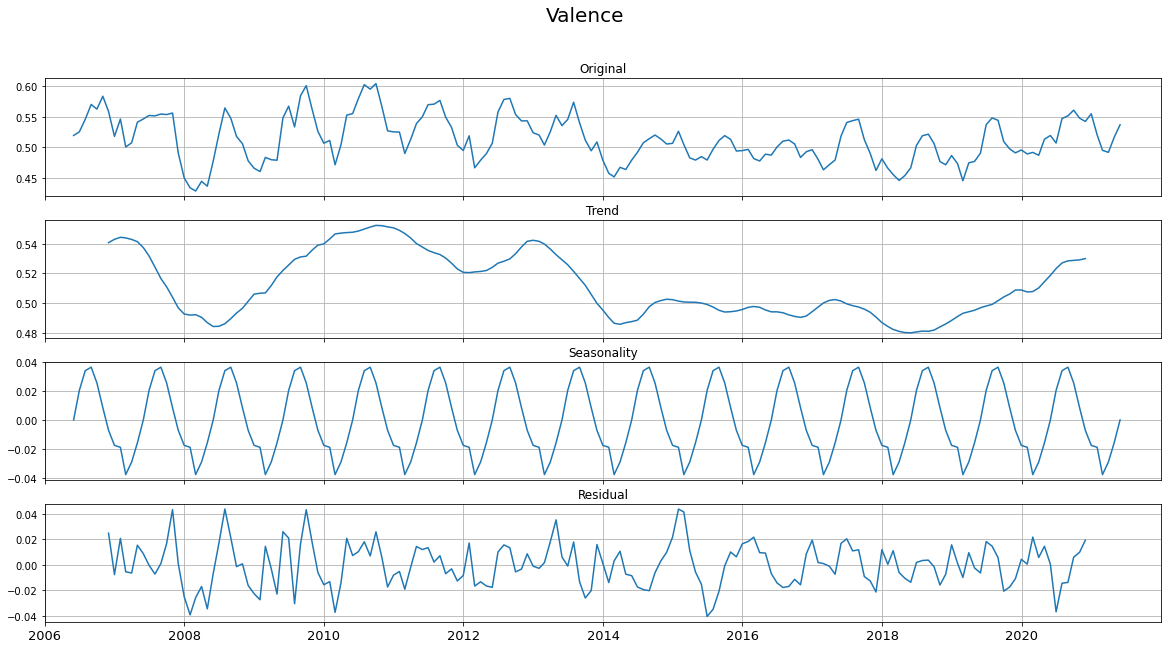

In [30]:
decomposition_plot (valence, trend_valence, seasonal_valence, residual_valence, "Valence")

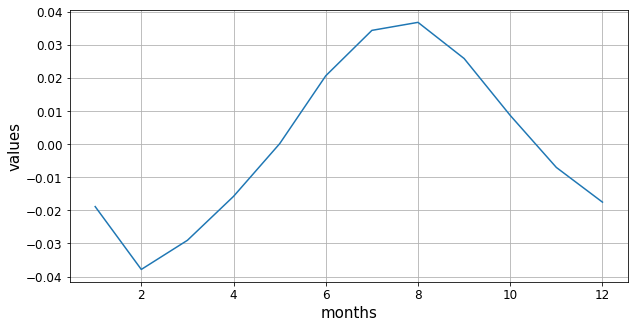

In [31]:
simple_seasonal_plot(noindex_valence)

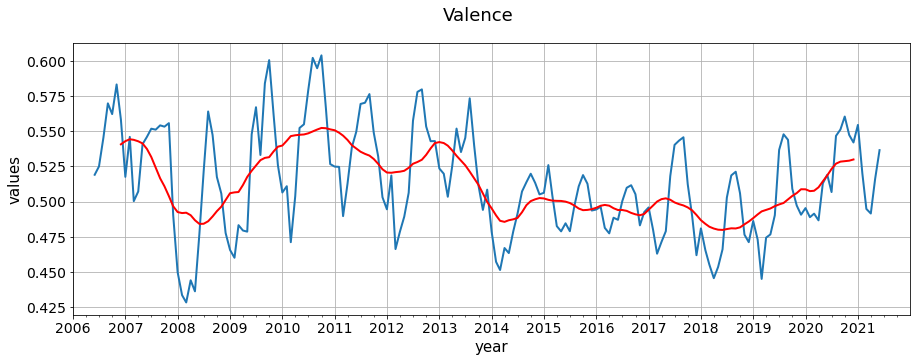

In [32]:
line_trend_plot (valence, trend_valence, title_plot = "Valence")

## Danceability

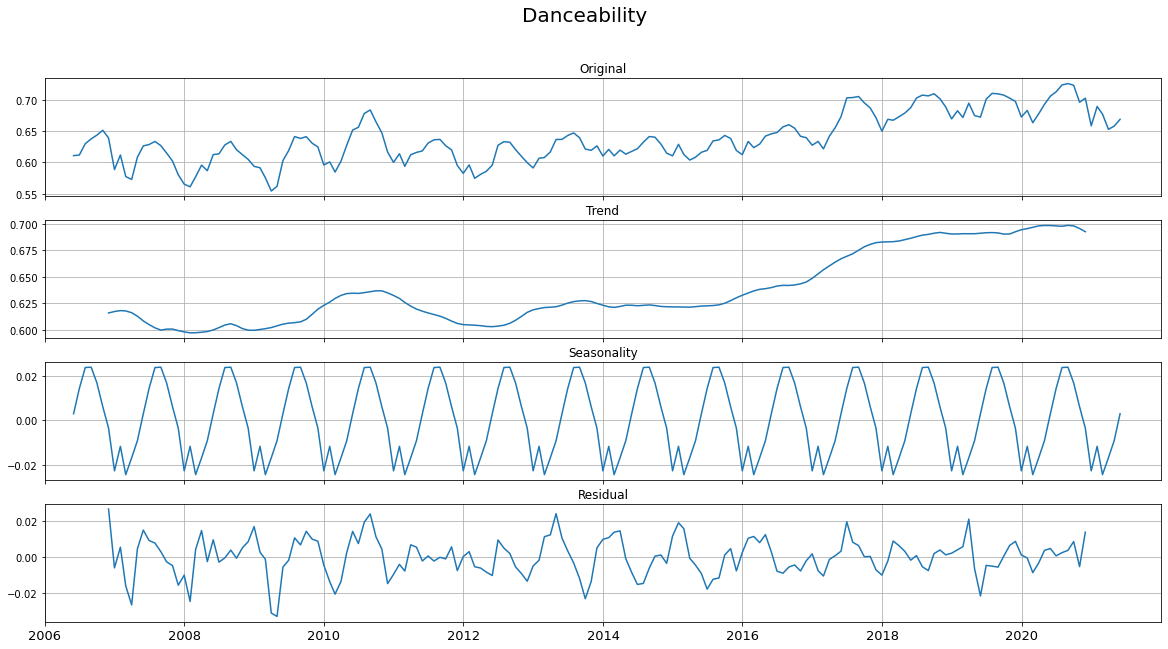

In [33]:
decomposition_plot (danceability, trend_danceability, seasonal_danceability, residual_danceability, "Danceability")

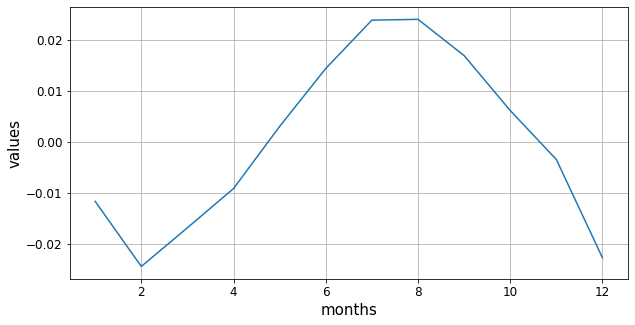

In [34]:
simple_seasonal_plot(noindex_danceability)

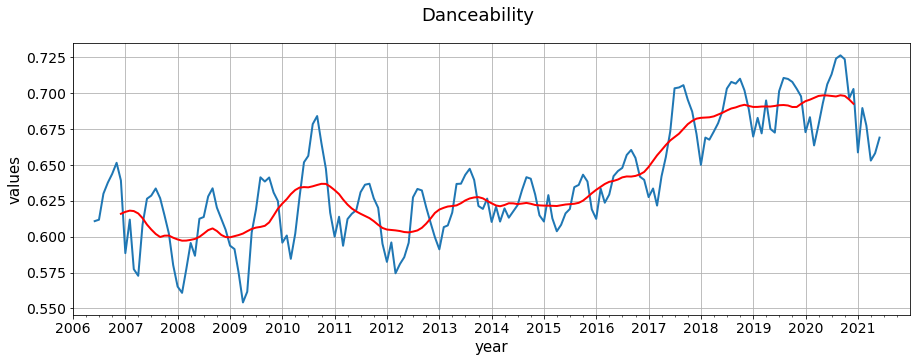

In [35]:
line_trend_plot (danceability, trend_danceability, title_plot = "Danceability")

# Energy

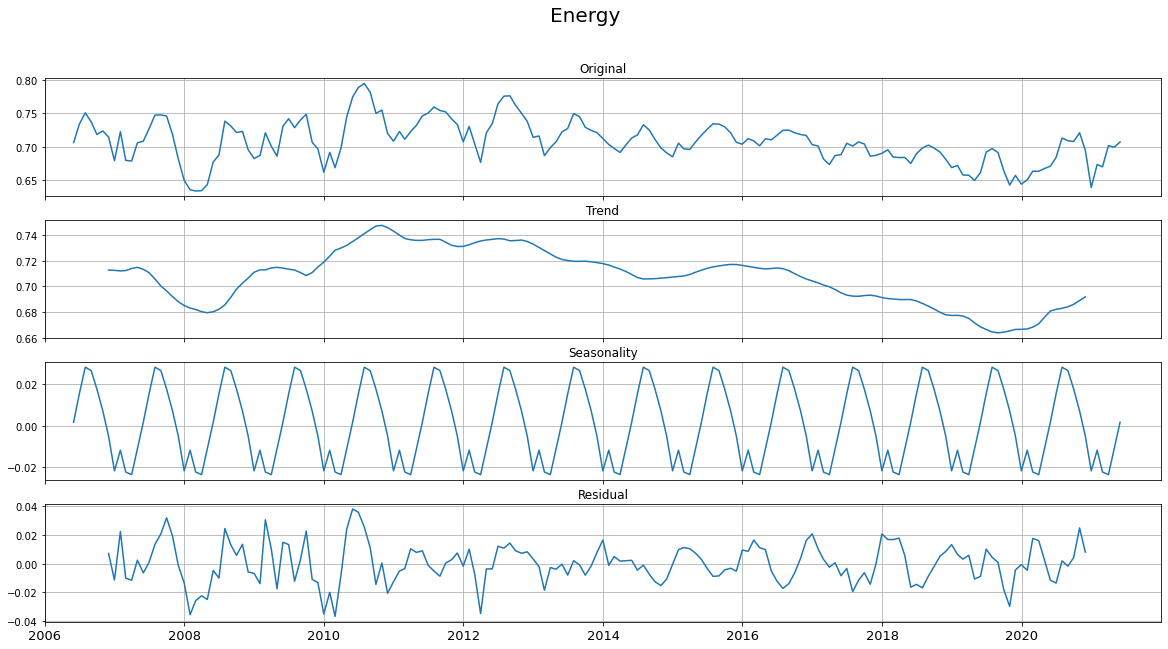

In [36]:
decomposition_plot (energy, trend_energy, seasonal_energy, residual_energy, "Energy")

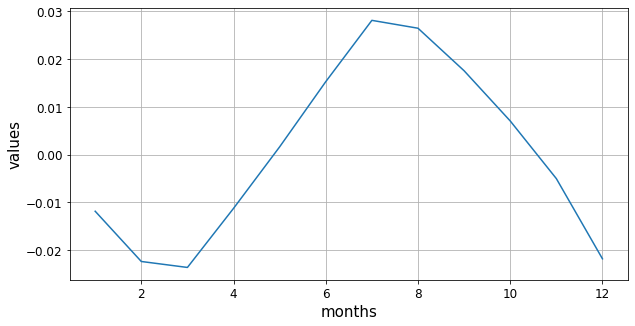

In [37]:
simple_seasonal_plot(noindex_energy)

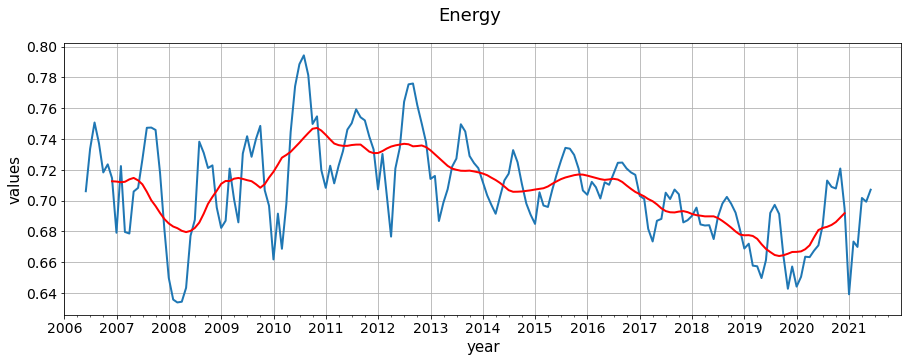

In [38]:
line_trend_plot (energy, trend_energy, title_plot = "Energy")

# Loudness

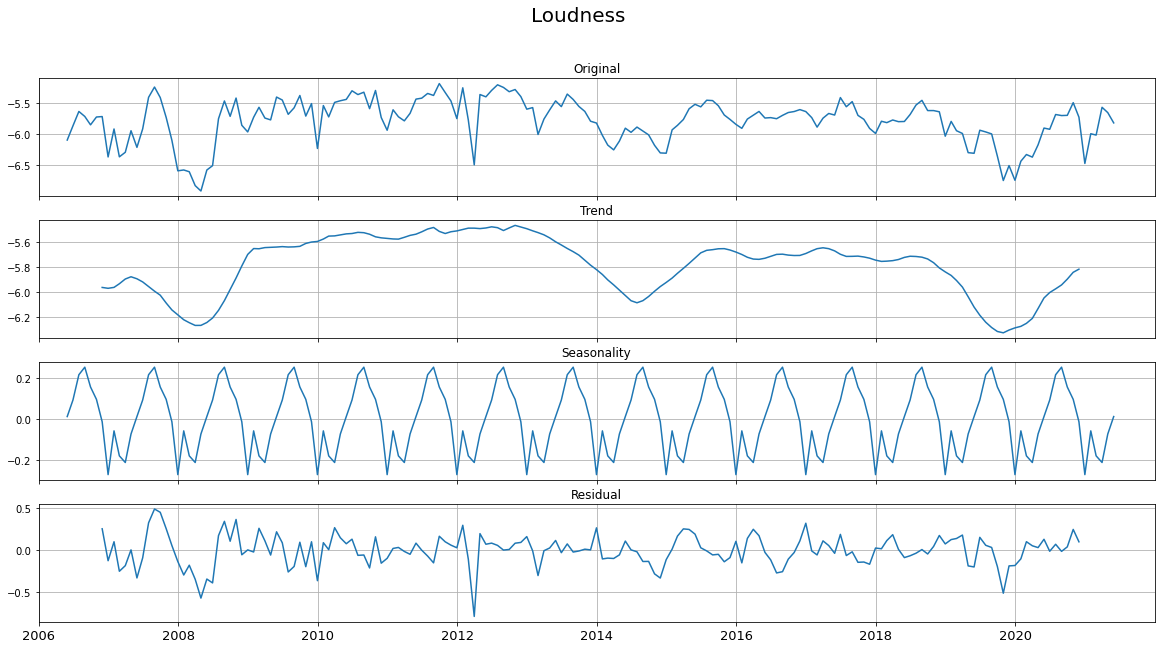

In [39]:
decomposition_plot (loudness, trend_loudness, seasonal_loudness, residual_loudness, "Loudness")

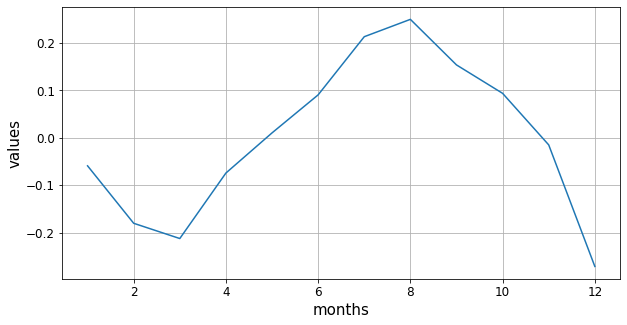

In [40]:
simple_seasonal_plot(noindex_loudness)

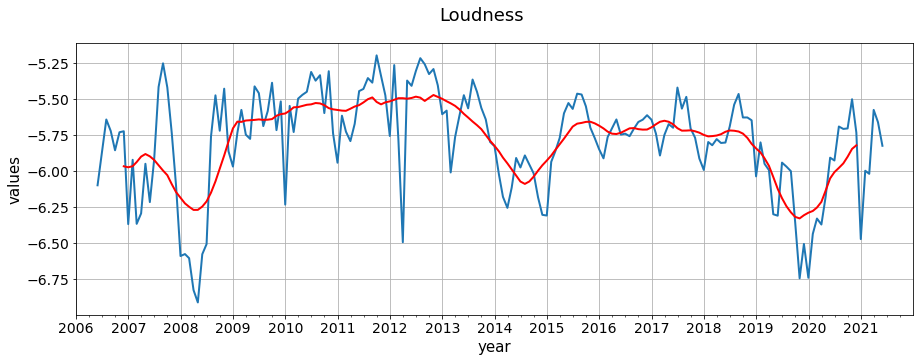

In [41]:
line_trend_plot (loudness, trend_loudness, title_plot = "Loudness")

# Mode

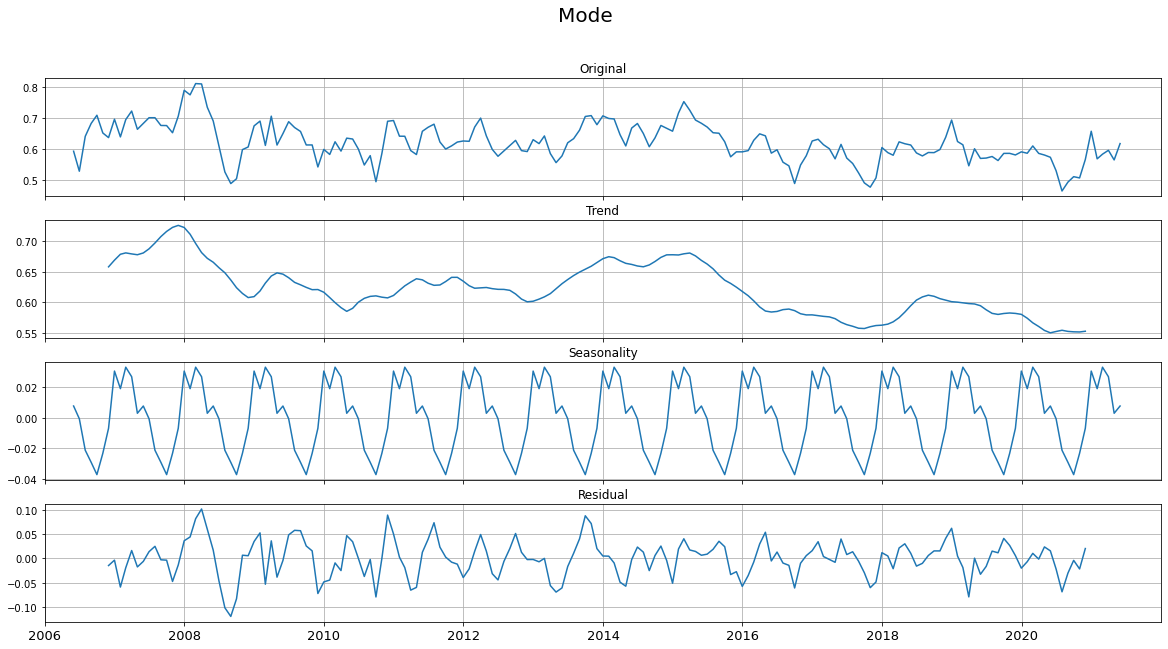

In [42]:
decomposition_plot (mode, trend_mode, seasonal_mode, residual_mode, "Mode")

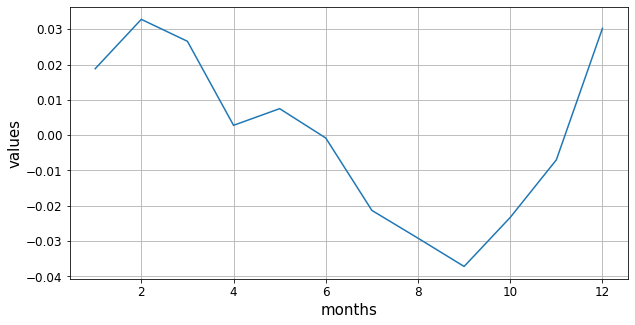

In [43]:
simple_seasonal_plot(noindex_mode)

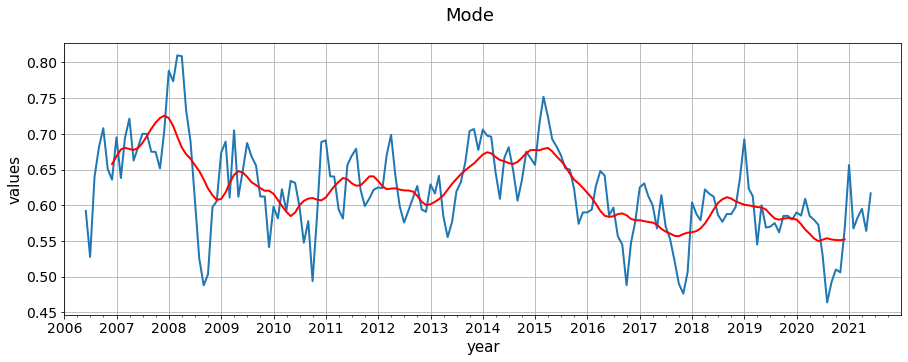

In [44]:
line_trend_plot (mode, trend_mode, title_plot = "Mode")

# Speechiness

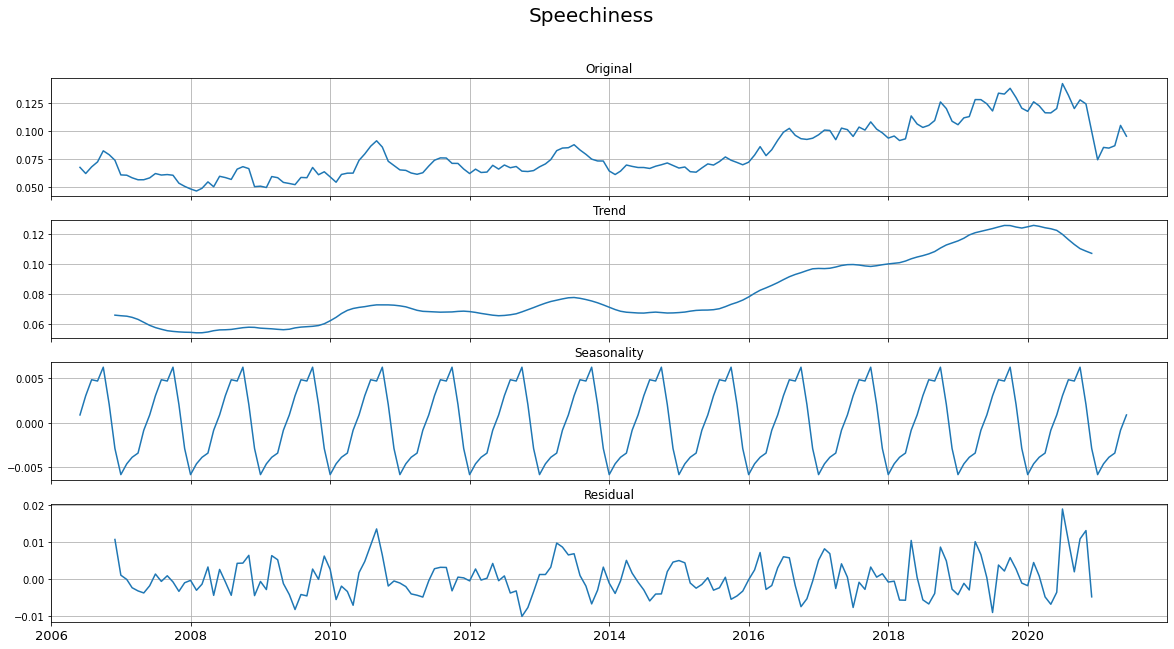

In [45]:
decomposition_plot (speechiness, trend_speechiness, seasonal_speechiness, residual_speechiness, "Speechiness")

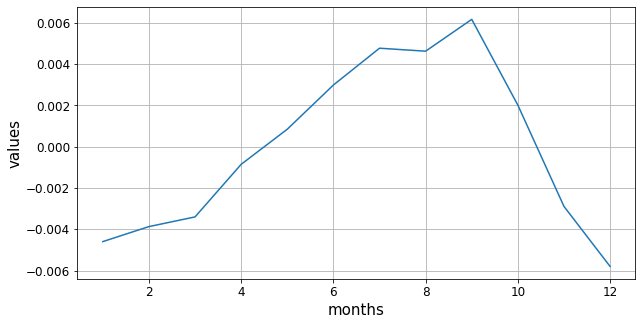

In [46]:
simple_seasonal_plot(noindex_speechiness)

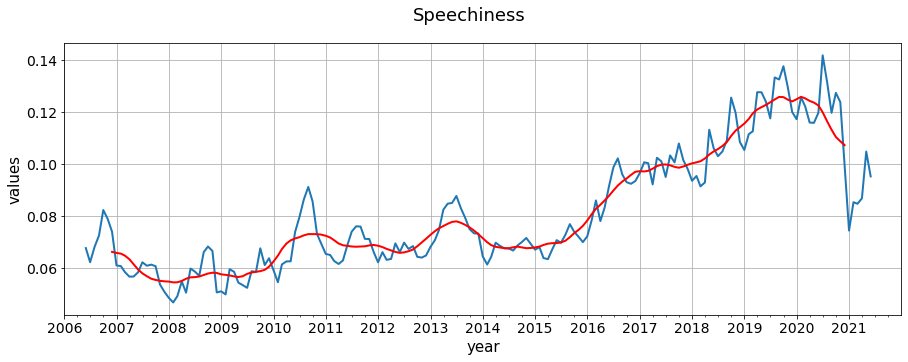

In [47]:
line_trend_plot (speechiness, trend_speechiness, title_plot = "Speechiness")

# Acousticness

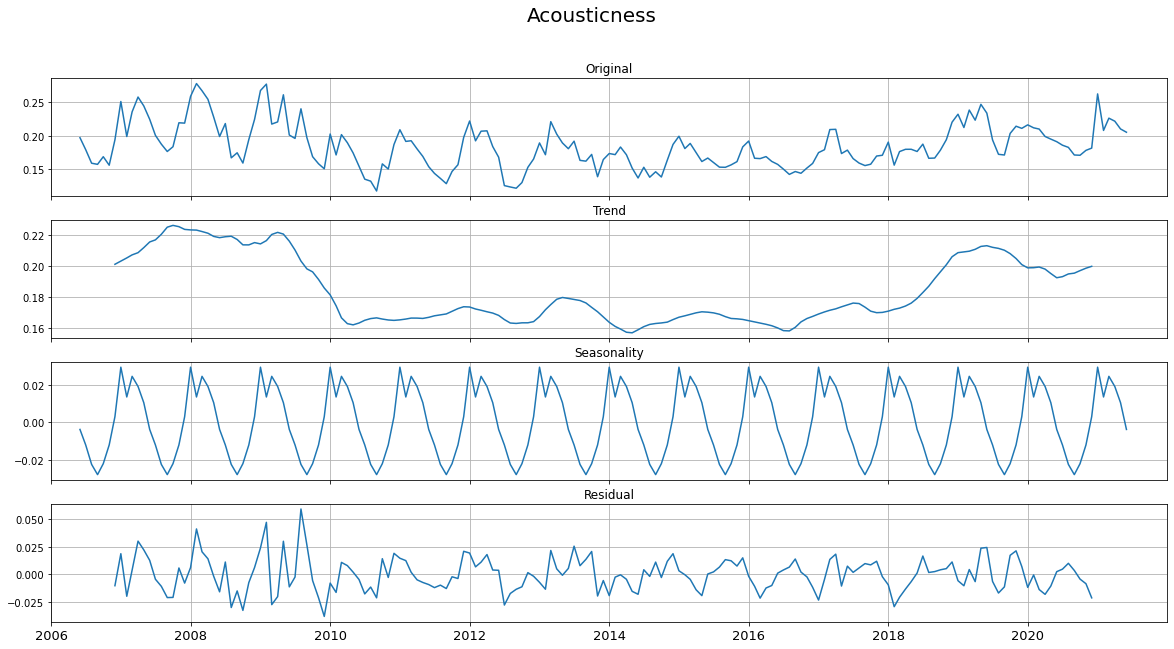

In [48]:
decomposition_plot (acousticness, trend_acousticness, seasonal_acousticness, residual_acousticness, "Acousticness")

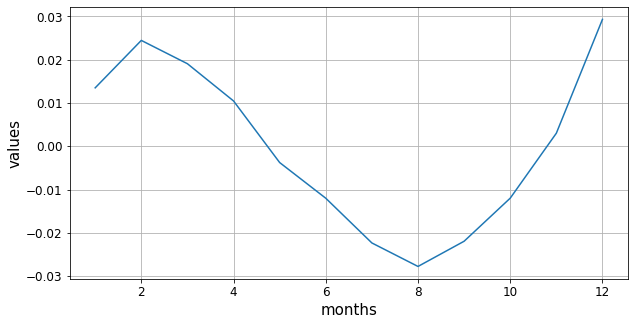

In [49]:
simple_seasonal_plot(noindex_acousticness)

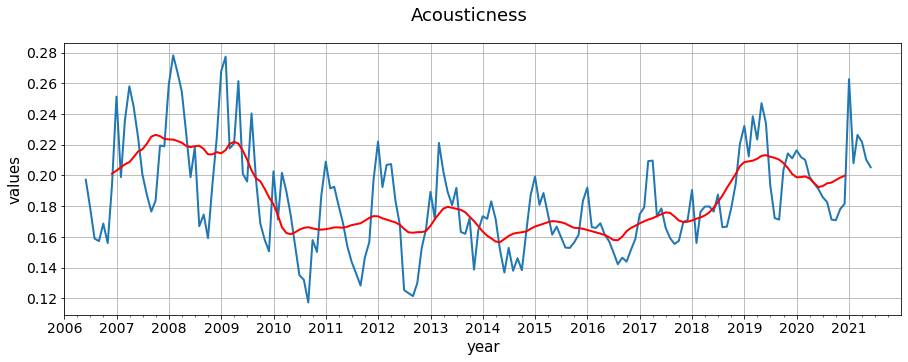

In [50]:
line_trend_plot (acousticness, trend_acousticness, title_plot = "Acousticness")

# Instrumentalness

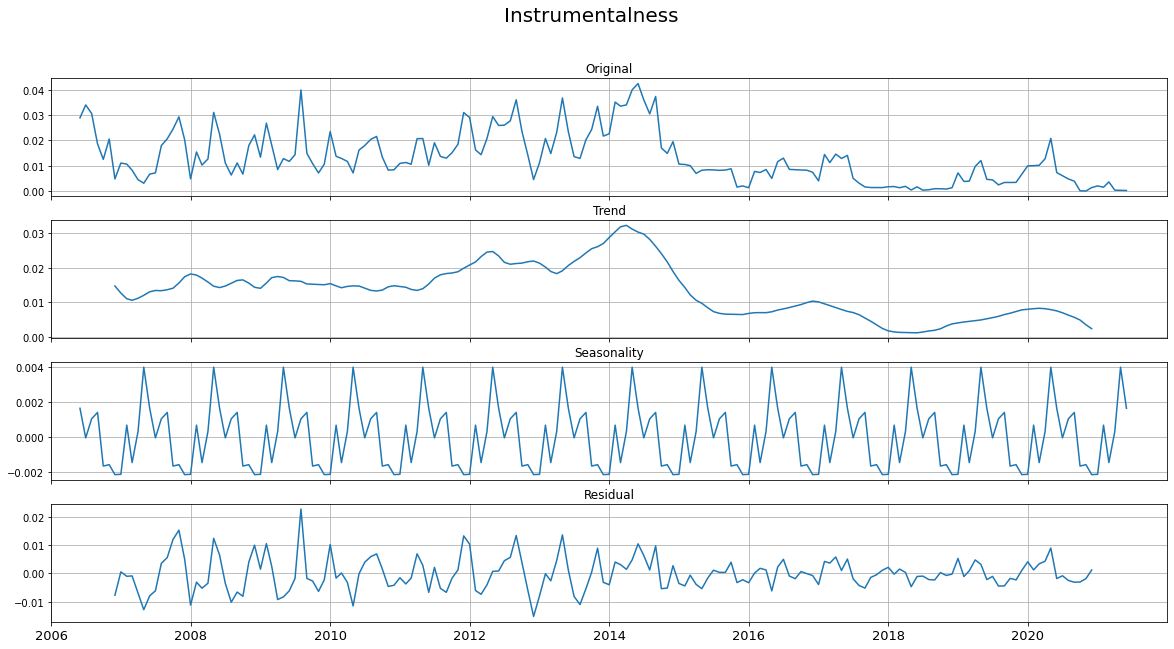

In [51]:
decomposition_plot (instrumentalness, trend_instrumentalness, seasonal_instrumentalness, residual_instrumentalness, "Instrumentalness")

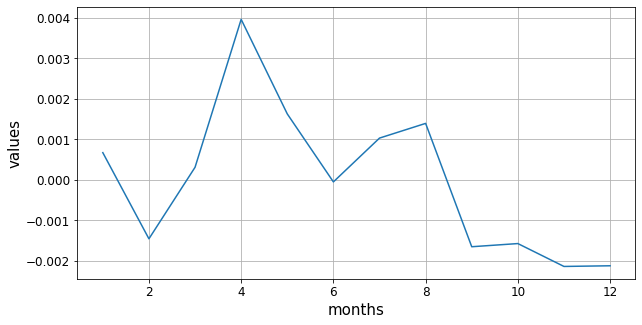

In [52]:
simple_seasonal_plot(noindex_instrumentalness)

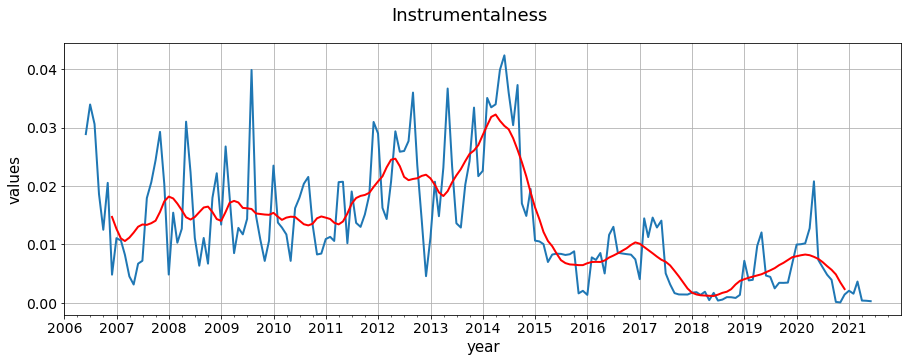

In [53]:
line_trend_plot (instrumentalness, trend_instrumentalness, title_plot = "Instrumentalness")

# Liveness

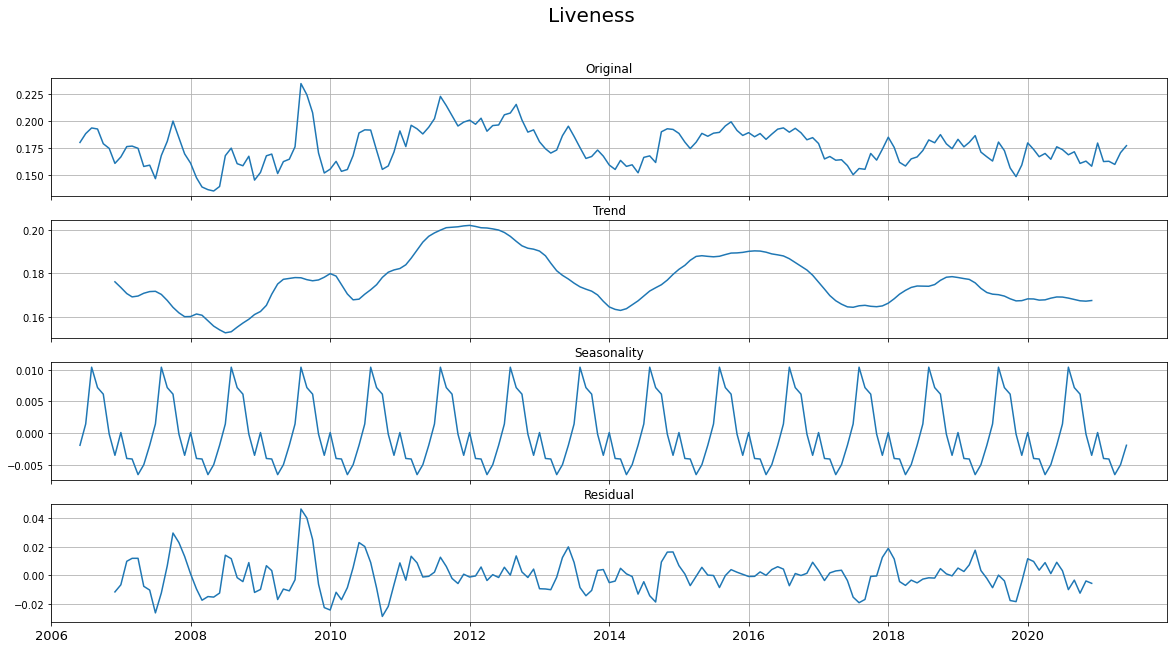

In [54]:
decomposition_plot (liveness, trend_liveness, seasonal_liveness, residual_liveness, "Liveness")

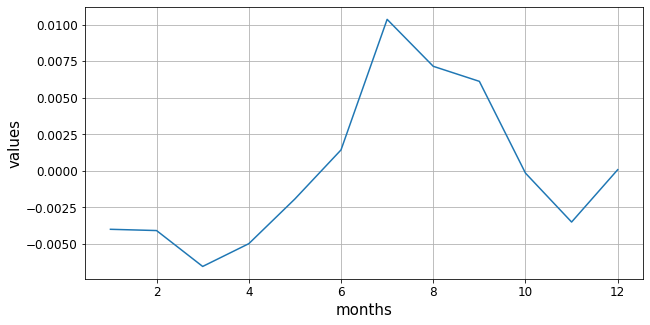

In [55]:
simple_seasonal_plot(noindex_liveness)

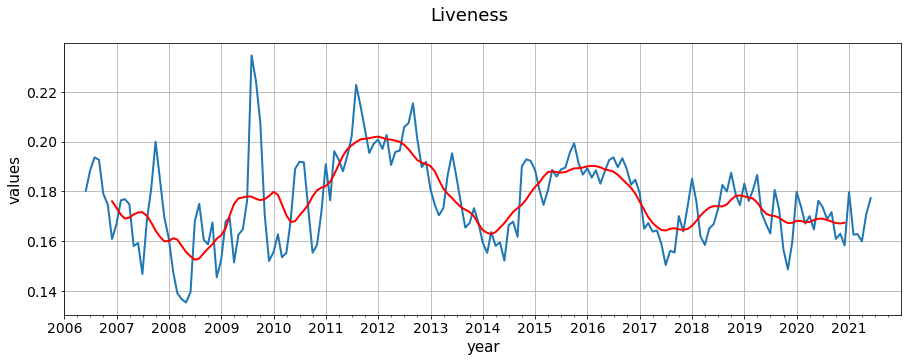

In [56]:
line_trend_plot (liveness, trend_liveness, title_plot = "Liveness")

# Tempo

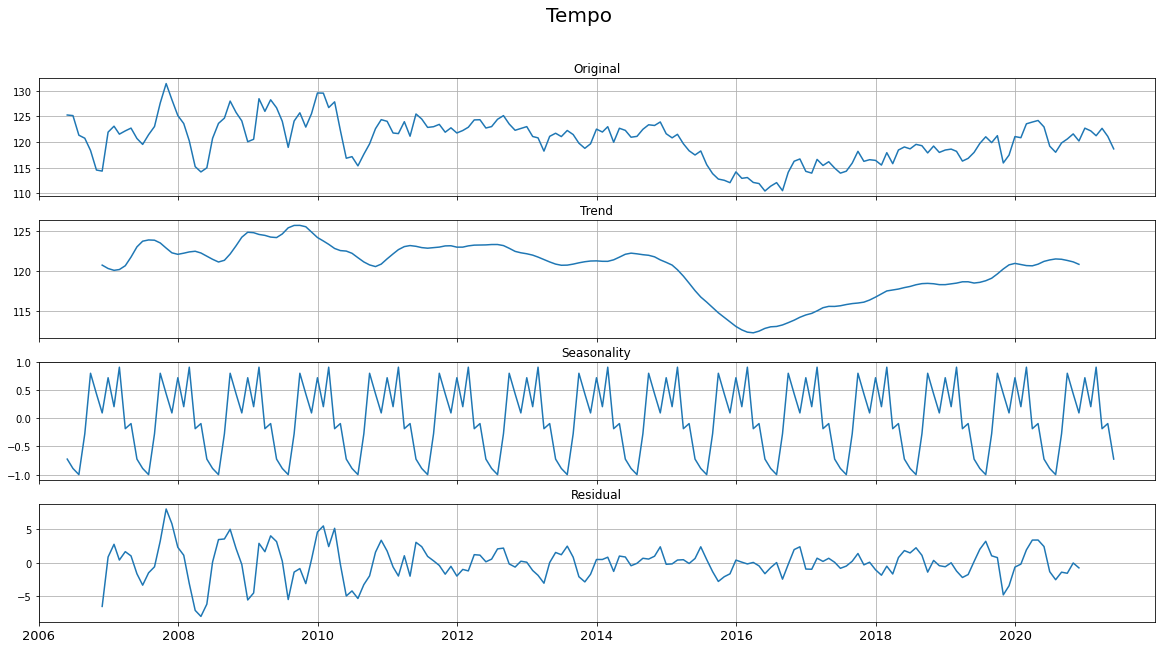

In [57]:
decomposition_plot (tempo, trend_tempo, seasonal_tempo, residual_tempo, "Tempo")

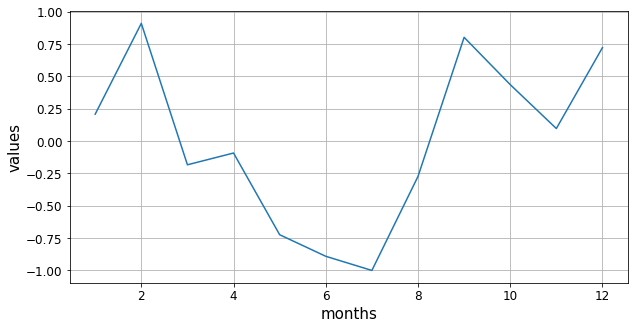

In [58]:
simple_seasonal_plot(noindex_tempo)

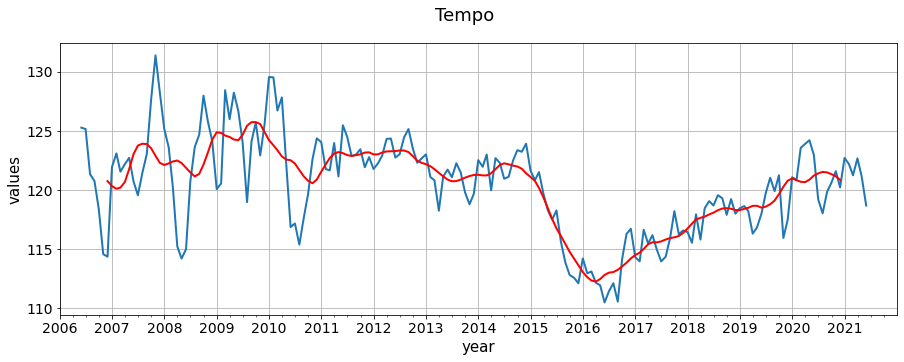

In [59]:
line_trend_plot (tempo, trend_tempo, title_plot = "Tempo")

# Example of normalized plot

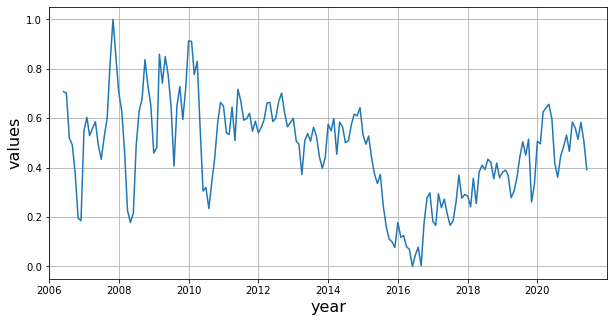

In [60]:
simple_plot (index = tempo, values = normalize_ts(tempo))

# GRAFICI

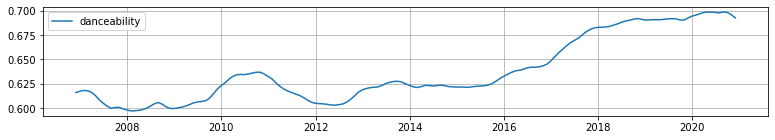

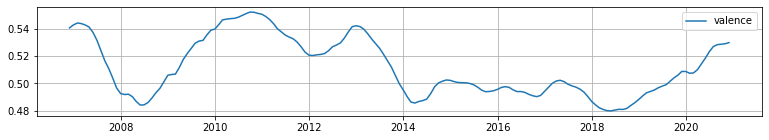

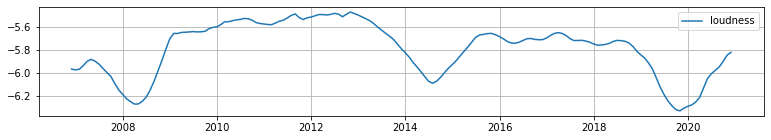

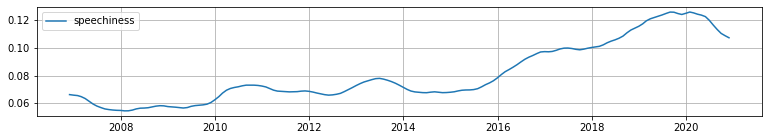

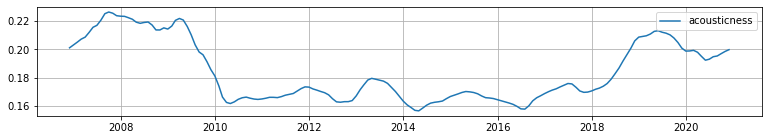

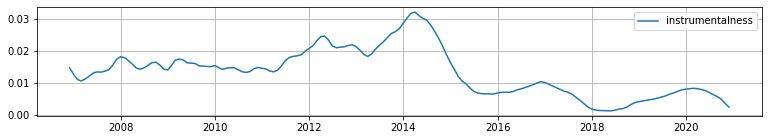

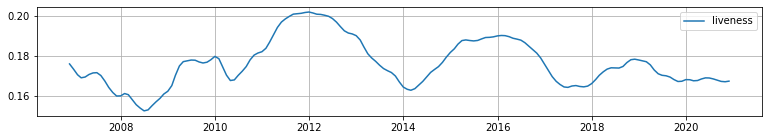

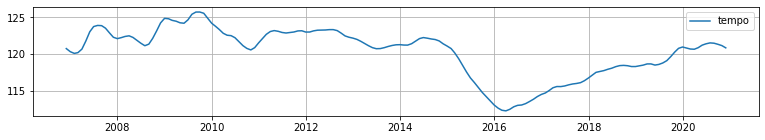

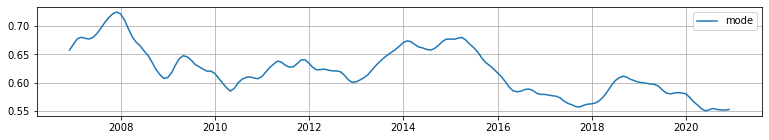

In [61]:
fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_danceability, label='danceability')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_valence, label='valence')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_loudness, label='loudness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_speechiness, label='speechiness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_acousticness, label='acousticness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_instrumentalness, label='instrumentalness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_liveness, label='liveness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_tempo, label='tempo')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(trend_mode, label='mode')
plt.legend(loc='best')

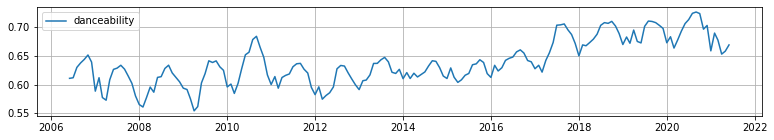

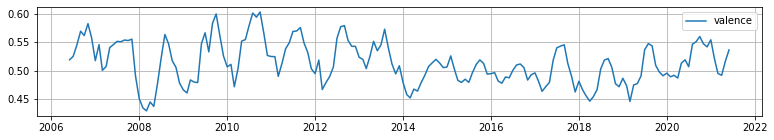

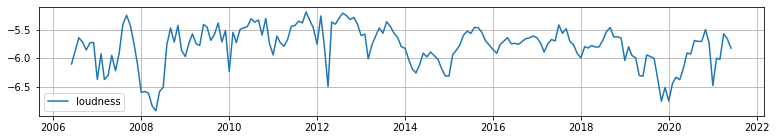

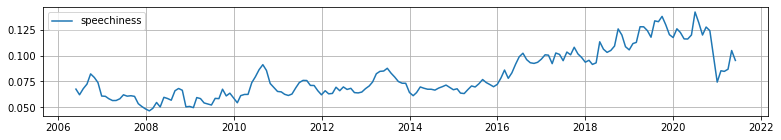

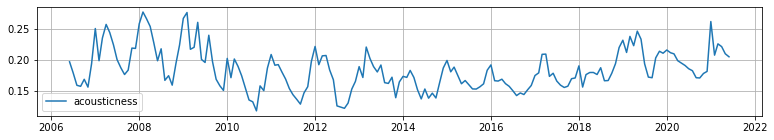

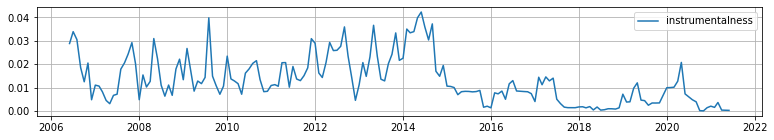

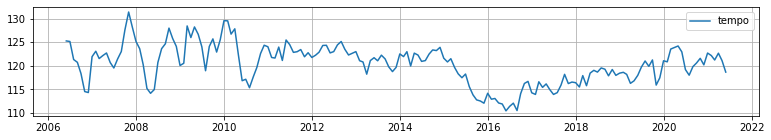

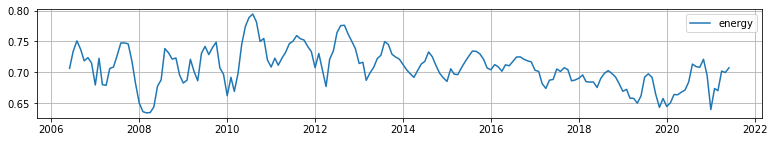

In [62]:
fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(danceability, label='danceability')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(valence, label='valence')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(loudness, label='loudness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(speechiness, label='speechiness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(acousticness, label='acousticness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(instrumentalness, label='instrumentalness')
plt.legend(loc='best')

#fig, ax = plt.subplots(figsize=(13,2))
#ax.grid(True)
#plt.plot(liveness, label='liveness')
#plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(tempo, label='tempo')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(energy, label='energy')
plt.legend(loc='best')

#fig, ax = plt.subplots(figsize=(13,2))
#ax.grid(True)
#plt.plot(mode, label='mode')
#plt.legend(loc='best')

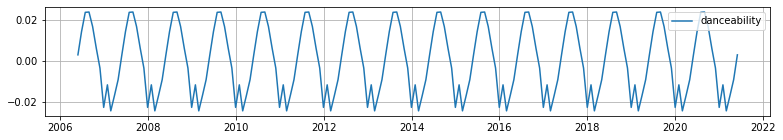

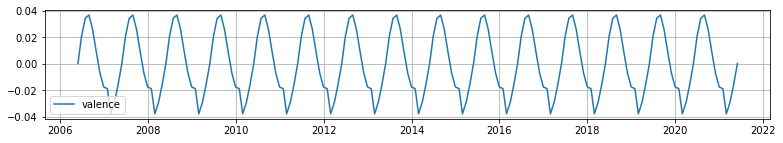

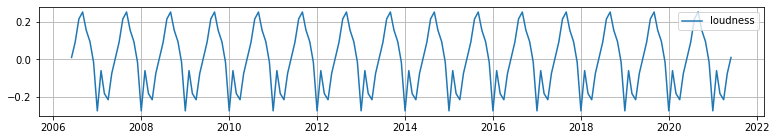

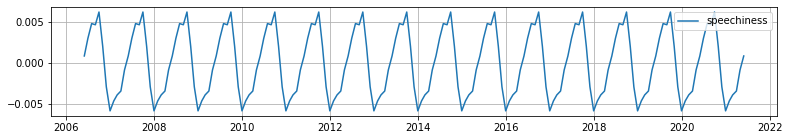

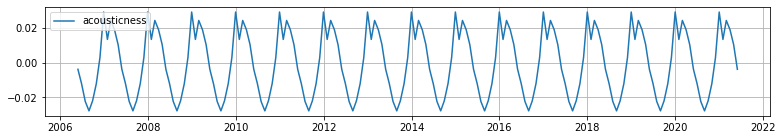

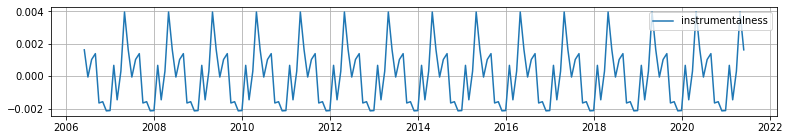

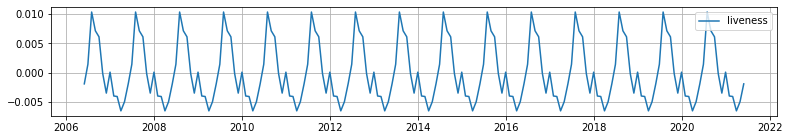

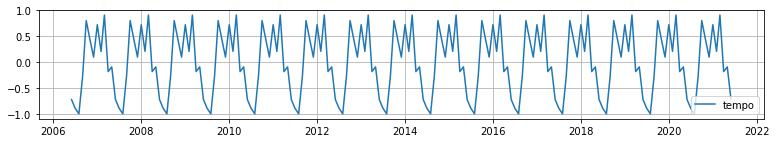

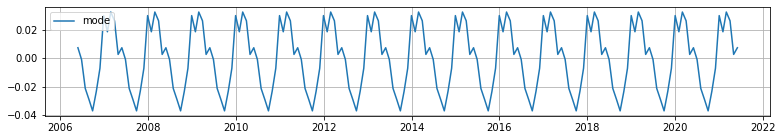

In [63]:
fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_danceability, label='danceability')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_valence, label='valence')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_loudness, label='loudness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_speechiness, label='speechiness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_acousticness, label='acousticness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_instrumentalness, label='instrumentalness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_liveness, label='liveness')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_tempo, label='tempo')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=(13,2))
ax.grid(True)
plt.plot(seasonal_mode, label='mode')
plt.legend(loc='best')

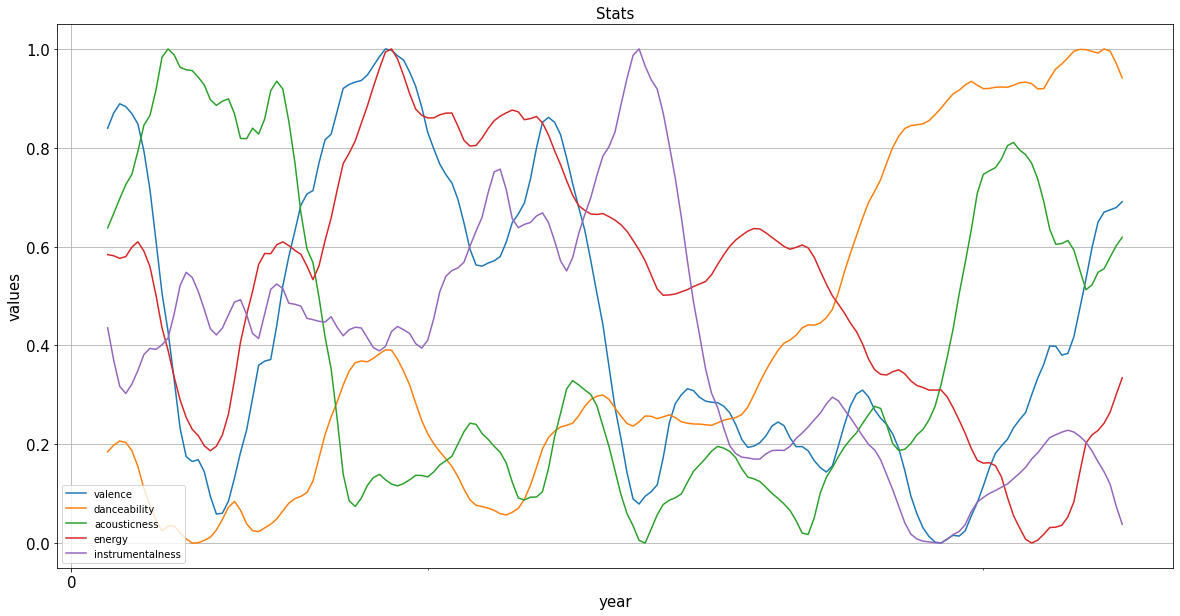

In [64]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)

plt.plot(normalize_ts(trend_valence), label="valence")
plt.plot(normalize_ts(trend_danceability), label="danceability")
#plt.plot(trend_speechiness - trend_speechiness.mean(), label="speechiness")
#plt.plot(trend_liveness - trend_liveness.mean(), label="liveness")
plt.plot(normalize_ts(trend_acousticness), label="acousticness")
plt.plot(normalize_ts(trend_energy), label="energy")
plt.plot(normalize_ts(trend_instrumentalness), label="instrumentalness")

#plt.plot(trend_mode - trend_mode.mean(), label="mode")
#plt.plot(trend_loudness - trend_loudness.mean(), label="loudness")
#plt.plot(trend_tempo - trend_tempo.mean(), label="tempo")
#plt.plot(trend_explicit - trend_explicit.mean(), label="explicit")
#plt.plot(trend_duration - trend_duration.mean(), label="duration")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("year", fontsize=15)
ax.set_ylabel("values", fontsize=15)

#plt.savefig("stats.png", dpi=300)

plt.show()

# Seasonality

## Danceability

C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

Text(0, 0.5, 'Danceability')

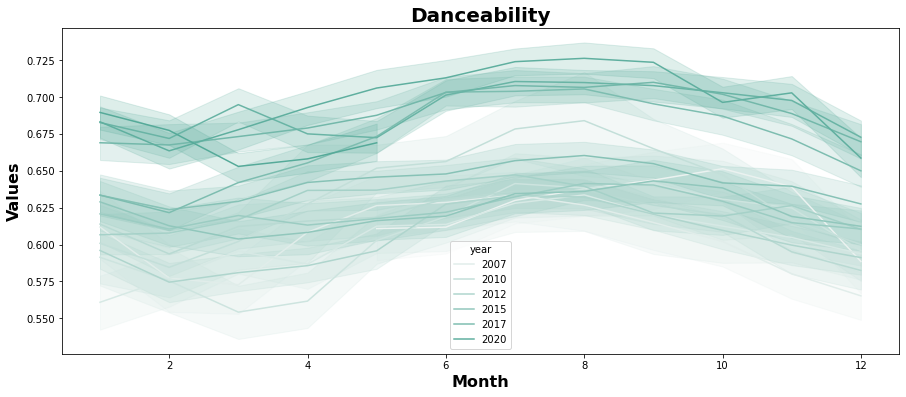

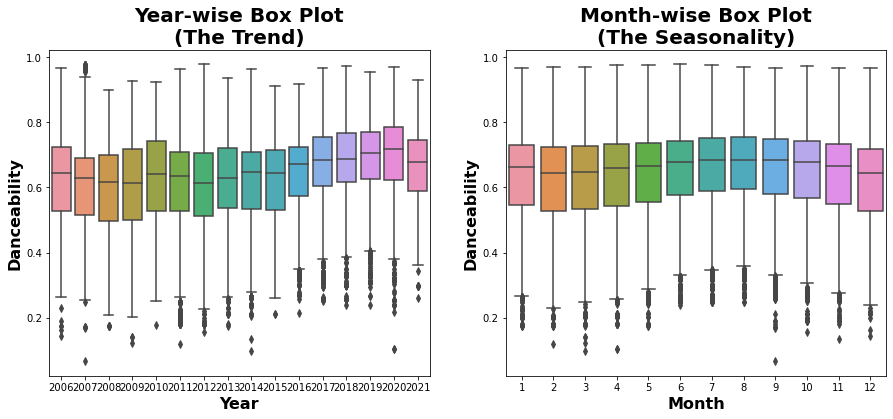

In [65]:
variable = 'danceability'
fig, ax = plt.subplots(figsize=(15, 6))

#palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
palette = sns.color_palette("light:#5A9", as_cmap=True)
sns.lineplot(dfnoindex['month'], dfnoindex[variable], hue=dfnoindex['year'], palette=palette)
ax.set_title('Danceability', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Values', fontsize = 16, fontdict=dict(weight='bold'))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(dfnoindex['year'], dfnoindex[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Danceability', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(dfnoindex['month'], dfnoindex[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Danceability', fontsize = 16, fontdict=dict(weight='bold'))

C:\Users\PC_CASA\anaconda3\envs\env_master\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Danceability')

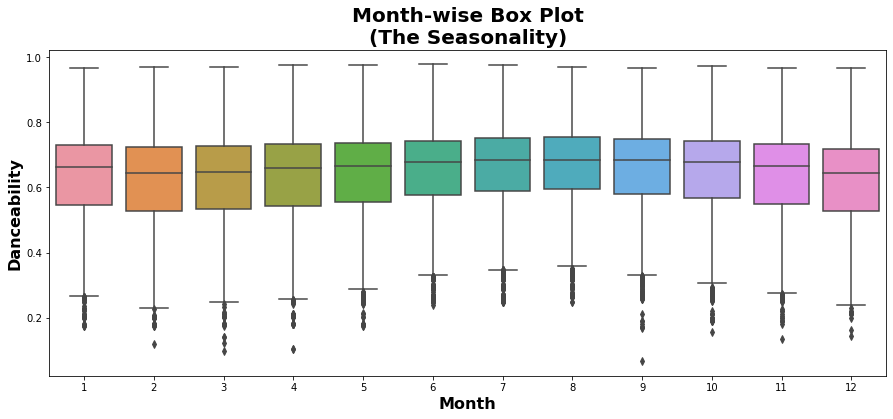

In [66]:
variable = "danceability"

fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(dfnoindex['month'], dfnoindex[variable])
ax.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Danceability', fontsize = 16, fontdict=dict(weight='bold'))

In [67]:
#Questa è la stagionalità decomposta

noindex_danceability

date_chart  seasonal
0   2006-05-31  0.003028
1   2006-06-30  0.014415
2   2006-07-31  0.023914
3   2006-08-31  0.024068
4   2006-09-30  0.016945
..         ...       ...
176 2021-01-31 -0.011707
177 2021-02-28 -0.024490
178 2021-03-31 -0.016885
179 2021-04-30 -0.009180
180 2021-05-31  0.003028

[181 rows x 2 columns]

<AxesSubplot:xlabel='date_chart'>

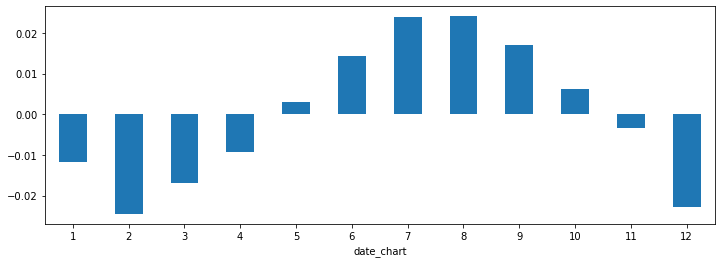

In [68]:
fig, axs = plt.subplots(figsize=(12, 4))

noindex_danceability.groupby(noindex_danceability["date_chart"].dt.month)["seasonal"].mean().plot(kind='bar', rot=0, ax=axs)

In [69]:
alt.Chart(noindex_danceability).mark_line(color='firebrick', strokeWidth=3).encode(
    x=alt.X('yearmonth(date_chart):T', axis=alt.Axis(title='Months')),
    y=alt.Y('seasonal:Q', axis=alt.Axis(title='Values'))
).properties(width=700, height=300, title="Danceability")

alt.Chart(...)

#### Tutte le seasonality

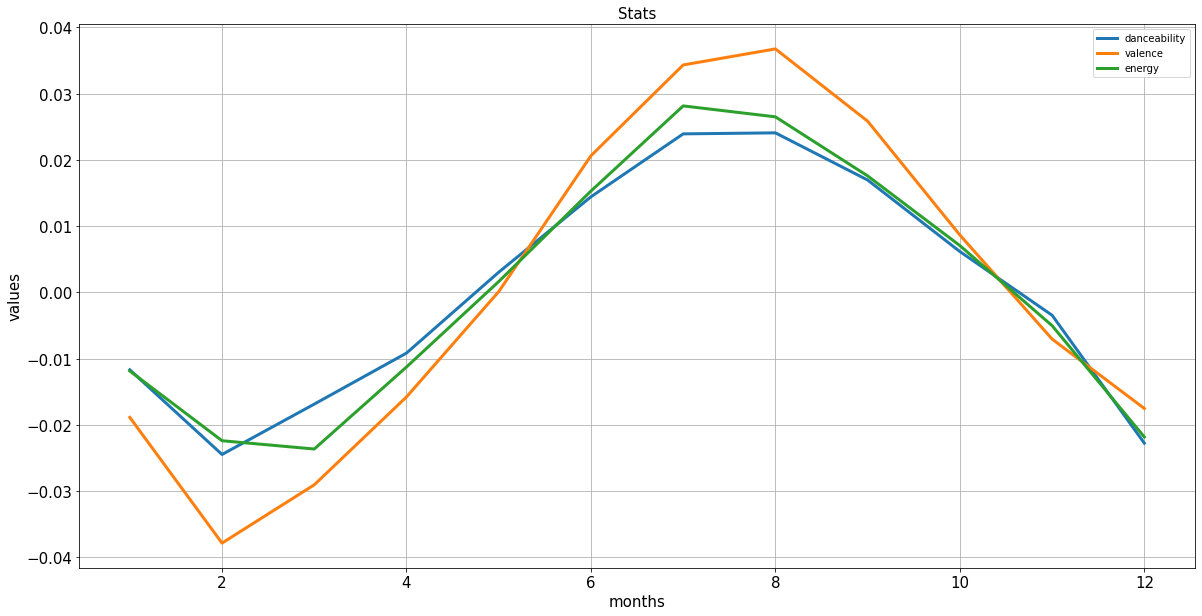

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

plt.plot(noindex_danceability.groupby(noindex_danceability["date_chart"].dt.month)["seasonal"].mean(), linewidth=3, label="danceability")
plt.plot(noindex_valence.groupby(noindex_valence["date_chart"].dt.month)["seasonal"].mean(), linewidth=3, label="valence")
plt.plot(noindex_energy.groupby(noindex_energy["date_chart"].dt.month)["seasonal"].mean(), linewidth=3, label="energy")
#plt.plot(noindex_loudness.groupby(noindex_loudness["date_chart"].dt.month)["seasonal"].mean(), label="loudness")

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='best')

ax.set_title("Stats", fontsize=15)
ax.set_xlabel("months", fontsize=15)
ax.set_ylabel("values", fontsize=15)

#plt.savefig("stats.png", dpi=300)

plt.show()

# Plots used for the interview to Bonalume and Varini

### Duration

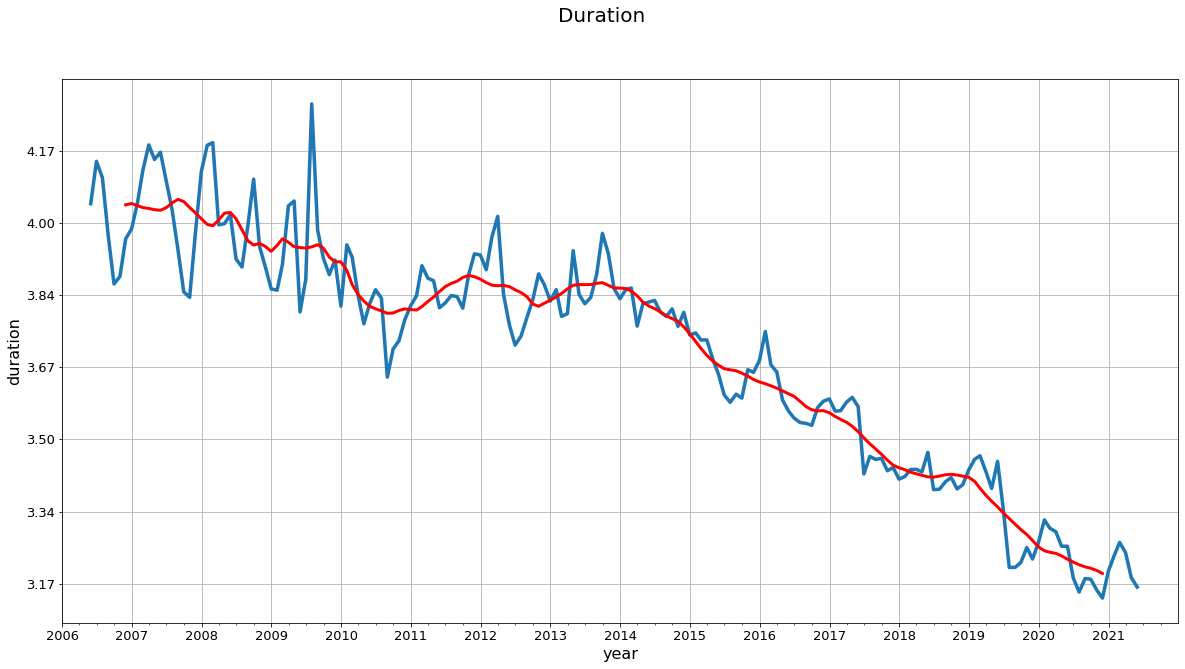

In [71]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

fig.suptitle('Duration', fontsize=20)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)
ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.plot(duration.index, duration, linewidth=3.5)
plt.plot(trend_duration.index, trend_duration, c='red', linewidth=3)

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(Decimal(str(x/60000)).quantize(Decimal('.01'), rounding=ROUND_UP)))
ax.yaxis.set_major_formatter(ticks)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 

plt.xlabel('year', fontsize=16)
plt.ylabel('duration', fontsize=16)

plt.savefig("duration.png", dpi=300, facecolor='w')

### Danceability, speechiness

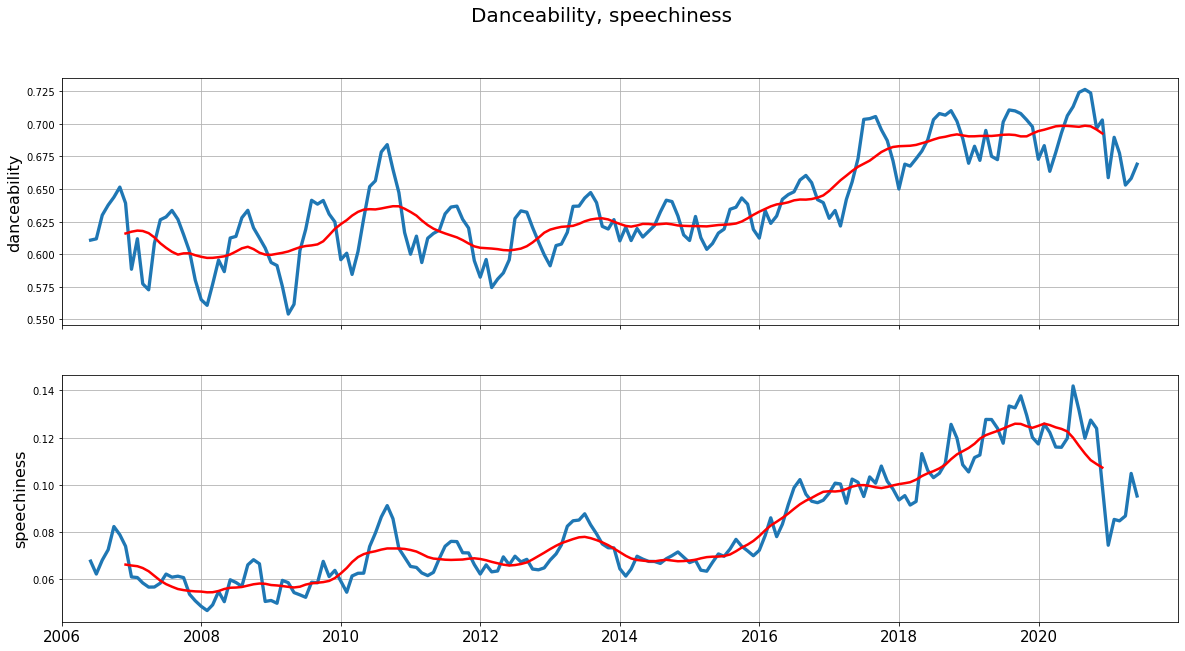

In [72]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20,10))


fig.suptitle('Danceability, speechiness', fontsize=20)

ax1.plot(danceability, label='danceability', linewidth=3.3)
ax1.grid(True)
ax1.set_ylabel('danceability',fontsize=16)
ax1.plot(trend_danceability.index, trend_danceability, c='red', linewidth=2.5)


ax2.plot(speechiness, label='speechiness', linewidth=3.3)
ax2.grid(True)
ax2.set_ylabel('speechiness',fontsize=16)
ax2.plot(trend_speechiness.index, trend_speechiness, c='red', linewidth=2.5)
ax2.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.xticks(fontsize=15) 

plt.savefig("danceability_speechiness.png", dpi=300, facecolor='w')

### Tempo, instrumentalness, valence

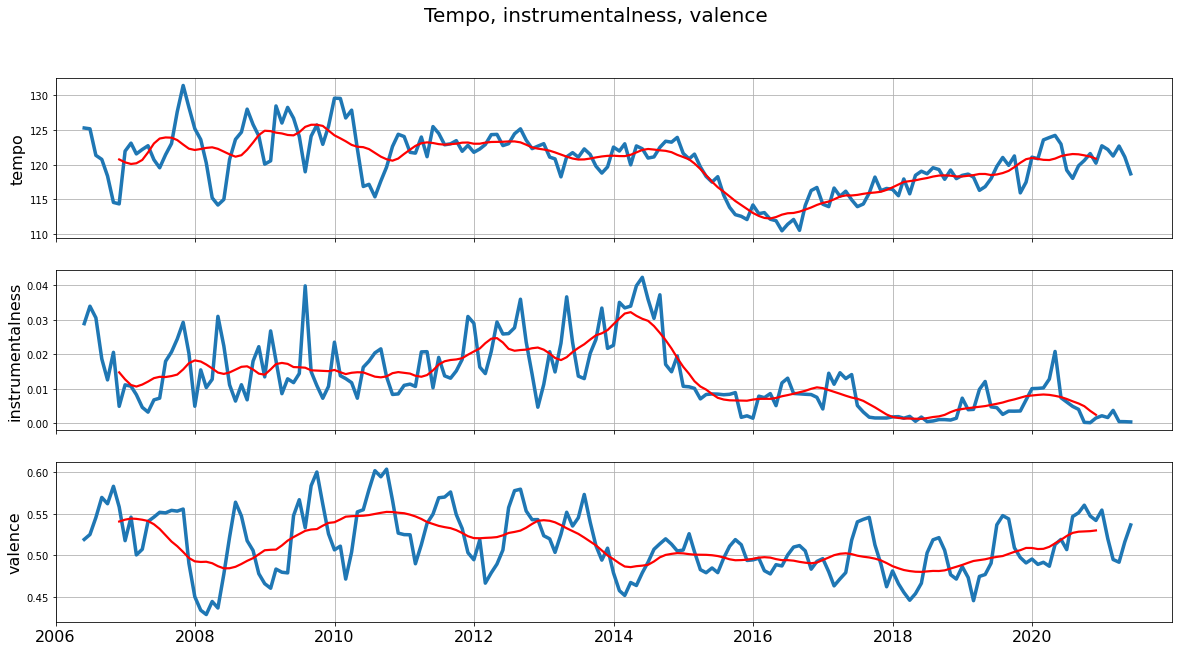

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))

fig.suptitle('Tempo, instrumentalness, valence', fontsize=20)


ax1.plot(tempo, label='tempo', linewidth=3.5)
ax1.grid(True)
ax1.set_ylabel('tempo',fontsize=16)
ax1.set_ylabel('tempo',fontsize=16)
ax1.plot(trend_tempo.index, trend_tempo, c='red', linewidth=2.2)

ax2.plot(instrumentalness, label='instrumentalness', linewidth=3.5)
ax2.grid(True)
ax2.set_ylabel('instrumentalness',fontsize=16)
ax2.plot(trend_instrumentalness.index, trend_instrumentalness, c='red', linewidth=2.2)

ax3.plot(valence, label='valence', linewidth=3.5)
ax3.grid(True)
ax3.set_ylabel('valence', fontsize=16)
ax3.set_ylabel('valence',fontsize=16)
ax3.plot(trend_valence.index, trend_valence, c='red', linewidth=2.2)
ax3.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.xticks(fontsize=16)

plt.savefig("Tempo_instrumentalness_valence.png", dpi=300, facecolor='w')

plt.show()


### acousticness, energy, loudness

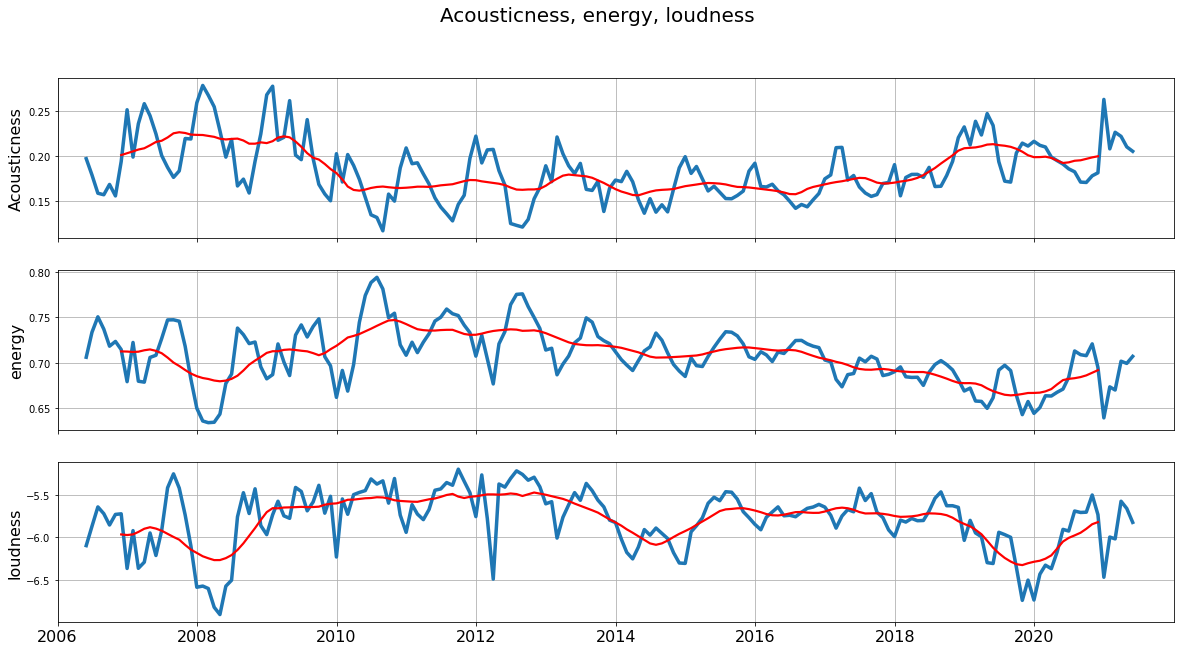

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20,10))

fig.suptitle('Acousticness, energy, loudness', fontsize=20)


ax1.plot(acousticness, label='Acousticness', linewidth=3.5)
ax1.grid(True)
ax1.set_ylabel('Acousticness',fontsize=16)
ax1.set_ylabel('Acousticness',fontsize=16)
ax1.plot(trend_acousticness.index, trend_acousticness, c='red', linewidth=2.2)

ax2.plot(energy, label='energy', linewidth=3.5)
ax2.grid(True)
ax2.set_ylabel('energy',fontsize=16)
ax2.plot(trend_energy.index, trend_energy, c='red', linewidth=2.2)

ax3.plot(loudness, label='loudness', linewidth=3.5)
ax3.grid(True)
ax3.set_ylabel('loudness', fontsize=16)
ax3.set_ylabel('loudness',fontsize=16)
ax3.plot(trend_loudness.index, trend_loudness, c='red', linewidth=2.2)
ax3.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.xticks(fontsize=16)

plt.savefig("Acousticness, energy, loudness.png", dpi=300, facecolor='w')

plt.show()

### Number of artists per song

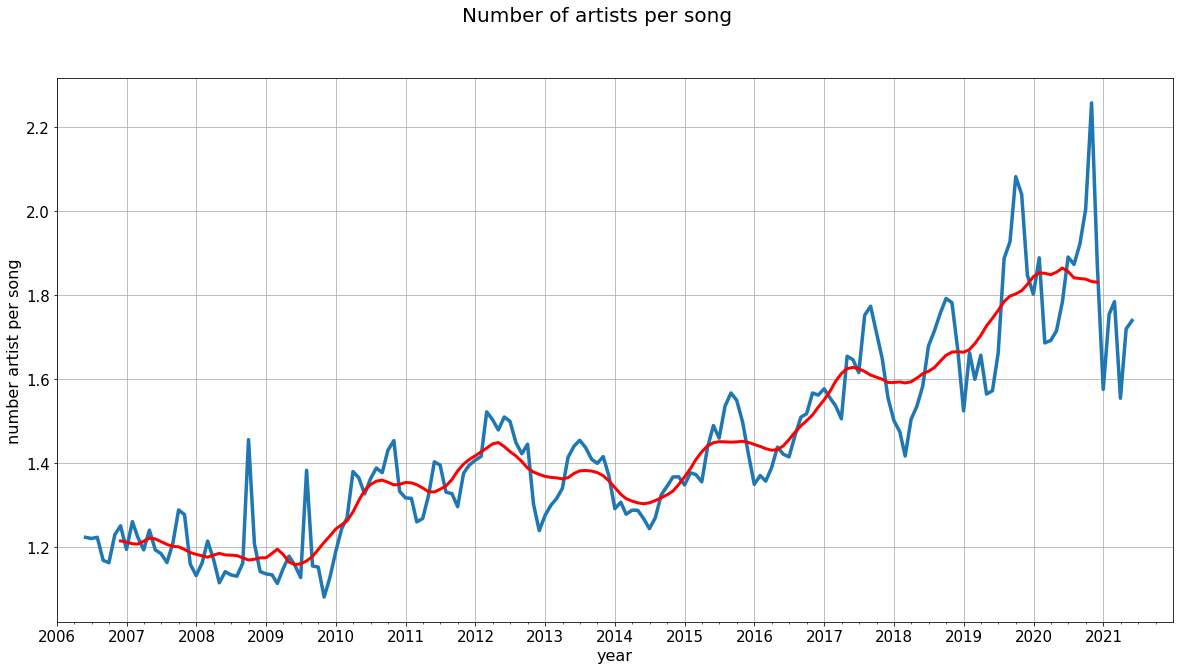

In [76]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

fig.suptitle('Number of artists per song', fontsize=20)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)
ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.plot(number_artists.index, number_artists, linewidth=3.5)
plt.plot(trend_number_artists.index, trend_number_artists, c='red', linewidth=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('year', fontsize=16)
plt.ylabel('number artist per song', fontsize=16)

plt.savefig("number_artists_song.png", dpi=300, facecolor='w')

plt.show()

### Explicit

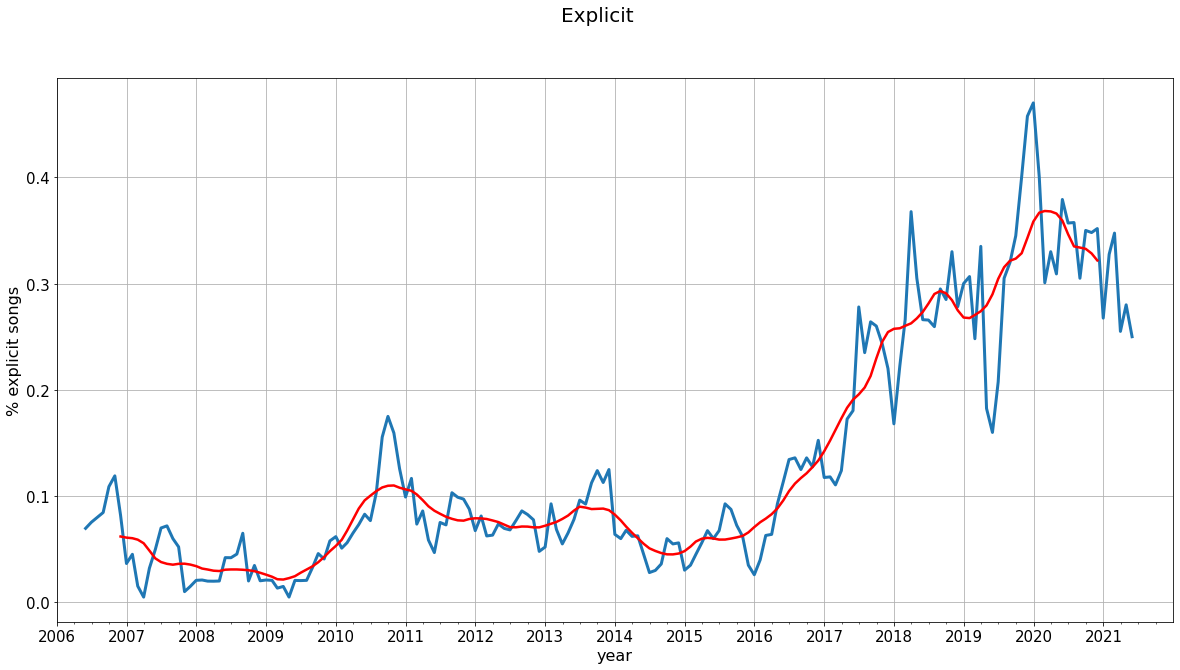

In [77]:
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(True)

fig.suptitle('Explicit', fontsize=20)

year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)

ax.xaxis.set_minor_locator(month)
ax.xaxis.set_major_locator(year)
ax.set_xlim([datetime.date(2006,1, 1), datetime.date(2021, 12, 31)])

plt.plot(explicit.index, explicit, linewidth=3)
plt.plot(trend_explicit.index, trend_explicit, c='red', linewidth=2.5)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('year', fontsize=16)
plt.ylabel('% explicit songs', fontsize=16)

plt.savefig("explicit.png", dpi=300, facecolor='w')